# Explanation of Health Data Processing Script

This script is designed to handle and process health-related data that is exported from a fitness tracking application. The data is typically in XML format and contains details about metrics such as the number of steps taken, flights climbed, and calories burned. The script reads this raw data, filters for specific metrics of interest, and transforms it into a structured format that is suitable for further analysis and visualization.

---

## **Data Parsing and Extraction**

The script begins by importing necessary libraries like Pandas, Matplotlib, and Seaborn for data manipulation and visualization. Additionally, it uses Python's built-in `xml.etree.ElementTree` library to parse the XML file containing the health data.

Once the XML file is loaded, the script iterates over each record in the dataset. It extracts key attributes, such as the type of metric (e.g., steps, flights climbed, or calories burned), the recorded value, and the date on which the data was collected. To ensure relevance, it filters the records to only include the metrics that are required for the analysis.

---

## **Data Transformation**

After extracting and filtering the relevant data, the script converts it into a Pandas DataFrame. This provides a tabular structure for the data, which makes it easier to work with.

To improve readability, the script renames the metric types to user-friendly labels:
- **Steps** for `HKQuantityTypeIdentifierStepCount`
- **Flights Climbed** for `HKQuantityTypeIdentifierFlightsClimbed`
- **Calories Burned** for `HKQuantityTypeIdentifierActiveEnergyBurned`

---

## **Data Structuring**

To organize the data effectively, the script pivots the DataFrame so that:
- Each row represents a single date.
- Each column represents a specific metric (steps, flights climbed, calories burned).
- The values are the aggregated totals for each metric on a given date.

This transformation ensures that the data is structured in a way that facilitates analysis and visualization.

---

## **Handling Missing Data**

In some cases, there may be missing data for certain metrics on specific dates. To address this, the script fills all missing values with zeros. This ensures consistency in the dataset and avoids potential errors during analysis or visualization.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  # Optional, for other numerical operations
import xml.etree.ElementTree as ET

# Parse the XML file
tree = ET.parse("export.xml")  # Replace with your actual file path
root = tree.getroot()

# Extract records for Steps, Flights Climbed, and Calories Burned
data = []
for record in root.findall("Record"):
    record_type = record.attrib.get("type")
    value = float(record.attrib.get("value", 0))
    date = pd.to_datetime(record.attrib.get("startDate", "").split(" ")[0])

    # Filter only relevant data types
    if record_type in [
        "HKQuantityTypeIdentifierStepCount", 
        "HKQuantityTypeIdentifierFlightsClimbed", 
        "HKQuantityTypeIdentifierActiveEnergyBurned"
    ]:
        data.append({"Date": date, "Type": record_type, "Value": value})

# Convert the data into a DataFrame
df_health = pd.DataFrame(data)

# Rename 'Type' for readability
df_health["Type"] = df_health["Type"].replace({
    "HKQuantityTypeIdentifierStepCount": "Steps",
    "HKQuantityTypeIdentifierFlightsClimbed": "Flights Climbed",
    "HKQuantityTypeIdentifierActiveEnergyBurned": "Calories Burned"
})

# Pivot the DataFrame to have metrics as columns
df_pivot_health = df_health.pivot_table(
    index="Date", columns="Type", values="Value", aggfunc="sum"
).reset_index()

# Fill missing values with 0
df_pivot_health.fillna(0, inplace=True)


# **Explanation of the Weekly Health Data Processing Code**

This section explains how the provided code processes and aggregates health data for weekly analysis.

---

## **1. Filtering Data for a Specific Date Range**

- The dataset is filtered to include only records from a specified date onward. 
- This ensures that only the relevant period is analyzed, making the data more manageable and focused for further processing.
- Filtering by date is especially useful when analyzing trends over a specific timeframe.

---

## **2. Adding Weekly and Daily Context**

### **WeekStart Calculation**
- Each date is assigned to the corresponding Monday of that week. This creates a `WeekStart` column, standardizing weekly data aggregation.
- For instance, if a date falls on a Thursday, it is adjusted back to the Monday of that week.

### **DayOfWeek Extraction**
- Each date is converted to its weekday name (e.g., Monday, Tuesday).
- This helps in identifying patterns related to specific days of the week.

These additions ensure that the data is structured with clear weekly and daily identifiers for further analysis.

---

## **3. Aggregating Data by Week and Day**

- The dataset is grouped by `WeekStart` and `DayOfWeek`. For each group, the total steps are calculated.
- This results in a summary table that shows the total steps for each day of the week, aggregated by week.
- Aggregation helps identify trends, such as whether activity levels vary significantly between weekdays and weekends.

---

## **4. Ensuring Correct Day Order**

- The days of the week are explicitly ordered (Monday to Sunday) to ensure consistency in the visualizations or reports.
- This prevents issues where days might appear out of order due to how the data is handled internally.

---

## **5. Creating a Week Label for Readability**

- A human-readable week label is created by combining the start and end dates of each week.
- For example, a week might be labeled as "23-Sep - 29-Sep."
- These labels provide clarity when presenting the data, making it easier to interpret results.

---

## **Purpose of the Entire Process**

This code transforms raw daily health data into a structured weekly format. The resulting summary table makes it easier to analyze activity trends, compare weekdays and weekends, and generate visualizations that highlight patterns in activity levels over time. This processing is a critical step for understanding long-term behavioral trends in health data.


In [2]:
# Filter data for the specific date range
df_pivot_health_filtered = df_pivot_health[df_pivot_health["Date"] >= "2024-09-23"].copy()

# Add WeekStart and DayOfWeek columns
df_pivot_health_filtered.loc[:, "WeekStart"] = df_pivot_health_filtered["Date"] - pd.to_timedelta(
    df_pivot_health_filtered["Date"].dt.weekday, unit="D"
)
df_pivot_health_filtered.loc[:, "DayOfWeek"] = df_pivot_health_filtered["Date"].dt.day_name()

# Aggregate data week by week and by day of the week
weekly_health_summary = df_pivot_health_filtered.groupby(
    ["WeekStart", "DayOfWeek"]
)["Steps"].sum().reset_index()

# Ensure days of the week are ordered correctly
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekly_health_summary["DayOfWeek"] = pd.Categorical(weekly_health_summary["DayOfWeek"], categories=day_order, ordered=True)

# Ensure the WeekLabel column is created in weekly_health_summary
weekly_health_summary["WeekLabel"] = weekly_health_summary["WeekStart"].dt.strftime("%d-%b") + " - " + (
    weekly_health_summary["WeekStart"] + pd.Timedelta(days=6)
).dt.strftime("%d-%b")


# **Explanation of the Weekly Steps Barplot Visualization Code**

This code block creates a barplot visualization to represent weekly step counts, categorized by days of the week. It uses a processed dataset (`weekly_health_summary`) that includes aggregated step counts for each day of the week across multiple weeks.

---

## **1. Preparing the Dataset**

### **Ensuring Correct Day Order**
- The `DayOfWeek` column is explicitly defined as a categorical variable with an ordered sequence: Monday to Sunday.
- This ensures that the days of the week are displayed in the correct order in the visualization, avoiding any sorting issues that could misrepresent the data.

---

## **2. Setting Up the Plot**

### **Figure and Axis Initialization**
- A new figure and axis object are created using Matplotlib's `plt.subplots` with a specified size of 16x6 inches. This size ensures that the barplot is spacious and readable.

---

## **3. Creating the Barplot**

### **Data Source and Axes**
- The dataset used is `weekly_health_summary`, which contains the aggregated step counts by day and week.
- The x-axis (`x`) represents the week ranges, as defined by the `WeekLabel` column. This makes it clear which week the data corresponds to.
- The y-axis (`y`) represents the total step counts for each day.

### **Color Coding by Day**
- The `hue` parameter is set to `DayOfWeek`, meaning that each bar is color-coded based on the day it represents.
- A `viridis` color palette is used, which provides a visually appealing gradient for distinguishing between days.

---

## **4. Enhancing the Plot**

### **Title and Labels**
- The plot is titled "Barplot - Weekly Step Count" to clearly indicate the purpose of the visualization.
- The x-axis is labeled "Week Range," and the y-axis is labeled "Steps" for clarity.

### **Rotating X-Axis Labels**
- To prevent overlap, the x-axis tick labels are rotated by 45 degrees, improving readability.

### **Legend Customization**
- A legend is added to indicate the color mapping for days of the week. The title is set as "Day of the Week," and the legend is positioned outside the plot using `bbox_to_anchor`.

---

## **5. Final Adjustments**

### **Layout Optimization**
- The `plt.tight_layout()` method ensures that the plot elements are adjusted to fit neatly within the figure canvas, avoiding any clipping of labels or legends.

---

## **Purpose of the Visualization**

This barplot provides a clear and organized view of weekly step counts, broken down by days of the week. It allows for easy comparison of activity levels across different days and weeks, highlighting patterns or anomalies in the data. This visualization is particularly useful for identifying trends such as consistently high or low activity days within a week or across weeks.


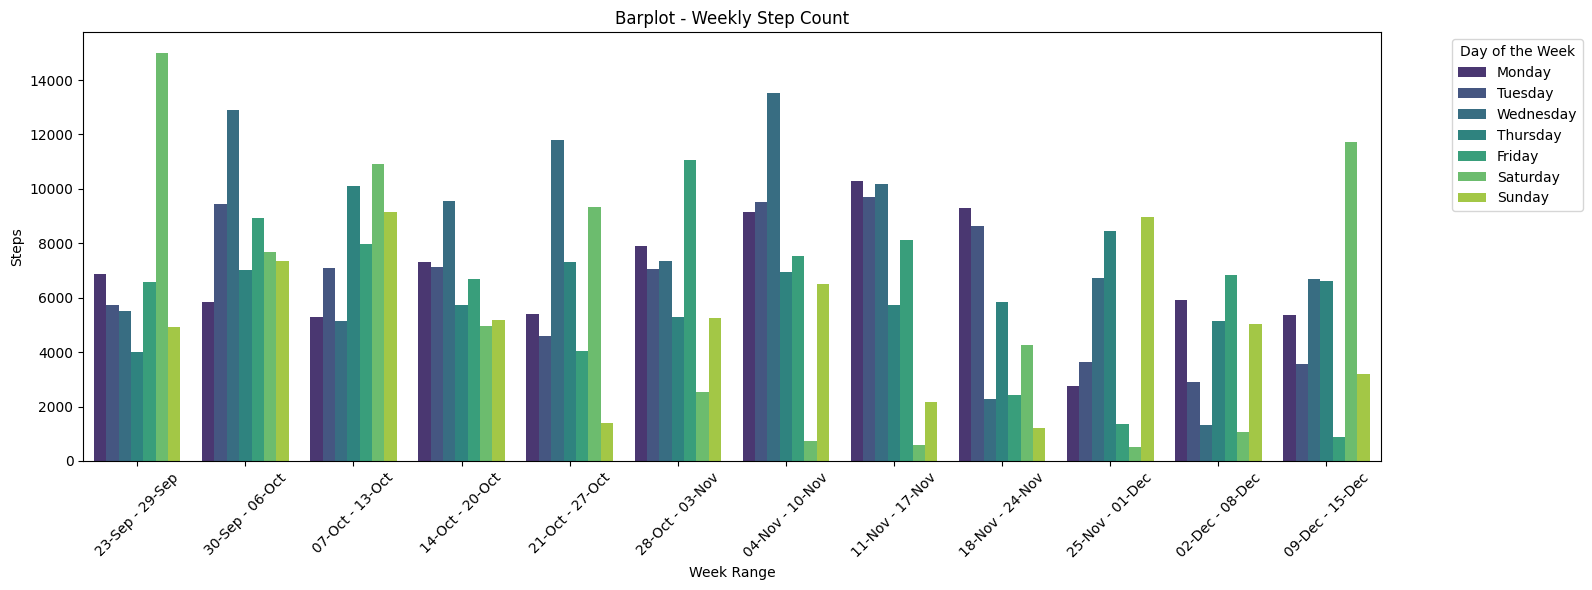

In [3]:
# Visualization Block
# Ensure necessary variables are available
weekly_health_summary["DayOfWeek"] = pd.Categorical(
    weekly_health_summary["DayOfWeek"], 
    categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
    ordered=True
)

# Plot for df_pivot_health
fig, ax = plt.subplots(figsize=(16, 6))

sns.barplot(
    data=weekly_health_summary,
    x="WeekLabel",  # Use WeekLabel for x-axis
    y="Steps",
    hue="DayOfWeek",
    ax=ax,
    palette="viridis"
)
ax.set_title("Barplot - Weekly Step Count")
ax.set_xlabel("Week Range")
ax.set_ylabel("Steps")
ax.tick_params(axis="x", rotation=45)
ax.legend(title="Day of the Week", bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()



# **Explanation of Daily Step Count Line Chart with Assignment Highlights**

This code creates a line chart to visualize daily step counts, with specific assignment dates highlighted using vertical lines and annotations. It helps identify trends or changes in activity levels around task dates.

---

## **1. Data Preparation**

### **Loading Data**
- The data (`df_pivot_health`) is assumed to be parsed from a source like `export.xml`.
- The `Date` column is converted into a datetime format using `pd.to_datetime` to enable date-based filtering and analysis.

### **Filtering Data**
- The dataset is filtered to include only data from September 23, 2024, onwards.
- This ensures that only relevant data for the analysis period is included.

### **Aggregating Daily Step Counts**
- The `Steps` column is aggregated by `Date` to calculate the total steps for each day.
- The result is stored in a new DataFrame (`daily_health_summary`) for further visualization.

---

## **2. Defining Events**

### **Task Events**
- A list of dictionaries (`events`) defines assignment dates and their names. Each dictionary contains:
  - `name`: The name of the event (e.g., "CS300 HW1").
  - `date`: The date of the event (e.g., "2024-10-27").
- The `event_dates` list contains the dates converted to datetime format.
- The `event_names` list contains the corresponding event names.

---

## **3. Visualizing the Data**

### **Initializing the Plot**
- A Matplotlib figure is created with a size of 20x10 inches for clear and detailed visualization.

### **Plotting Daily Step Counts**
- A line plot is generated with:
  - `Date` on the x-axis.
  - `Steps` on the y-axis.
  - Blue markers for daily step counts to make data points visually distinct.

---

## **4. Highlighting Events**

### **Adding Vertical Lines**
- For each task date, a vertical line (`axvline`) is drawn on the chart in red, with a dashed line style and semi-transparency (`alpha=0.7`).

### **Annotating Task Names**
- Each event name is annotated above the corresponding vertical line at 80% of the maximum step count for better visibility.

### **Conditional Annotation**
- Only events from October 1, 2024, onwards are annotated, ensuring relevance to the analysis period.

---

## **5. Customizing the Chart**

### **Title and Axis Labels**
- The chart is titled "Line Chart - Daily Step Count - Assignments Highlighted."
- The x-axis is labeled "Date," and the y-axis is labeled "Step Count."

### **X-Axis Formatting**
- X-axis tick labels are rotated by 45 degrees for better readability of dates.

### **Legend**
- A legend is added to identify task events and step counts. It is positioned outside the plot area for clarity.

### **Grid Lines**
- Horizontal grid lines (`grid`) are added along the y-axis with a dashed style and slight transparency to improve readability.

### **Layout Optimization**
- `plt.tight_layout()` adjusts the layout to prevent clipping of labels, legends, or other elements.

---

## **Purpose of the Visualization**

This chart provides a clear representation of daily activity levels while highlighting the timing of assignments. It allows for easy identification of patterns or changes in activity levels around specific task dates, helping to evaluate the impact of assignments on daily routines.


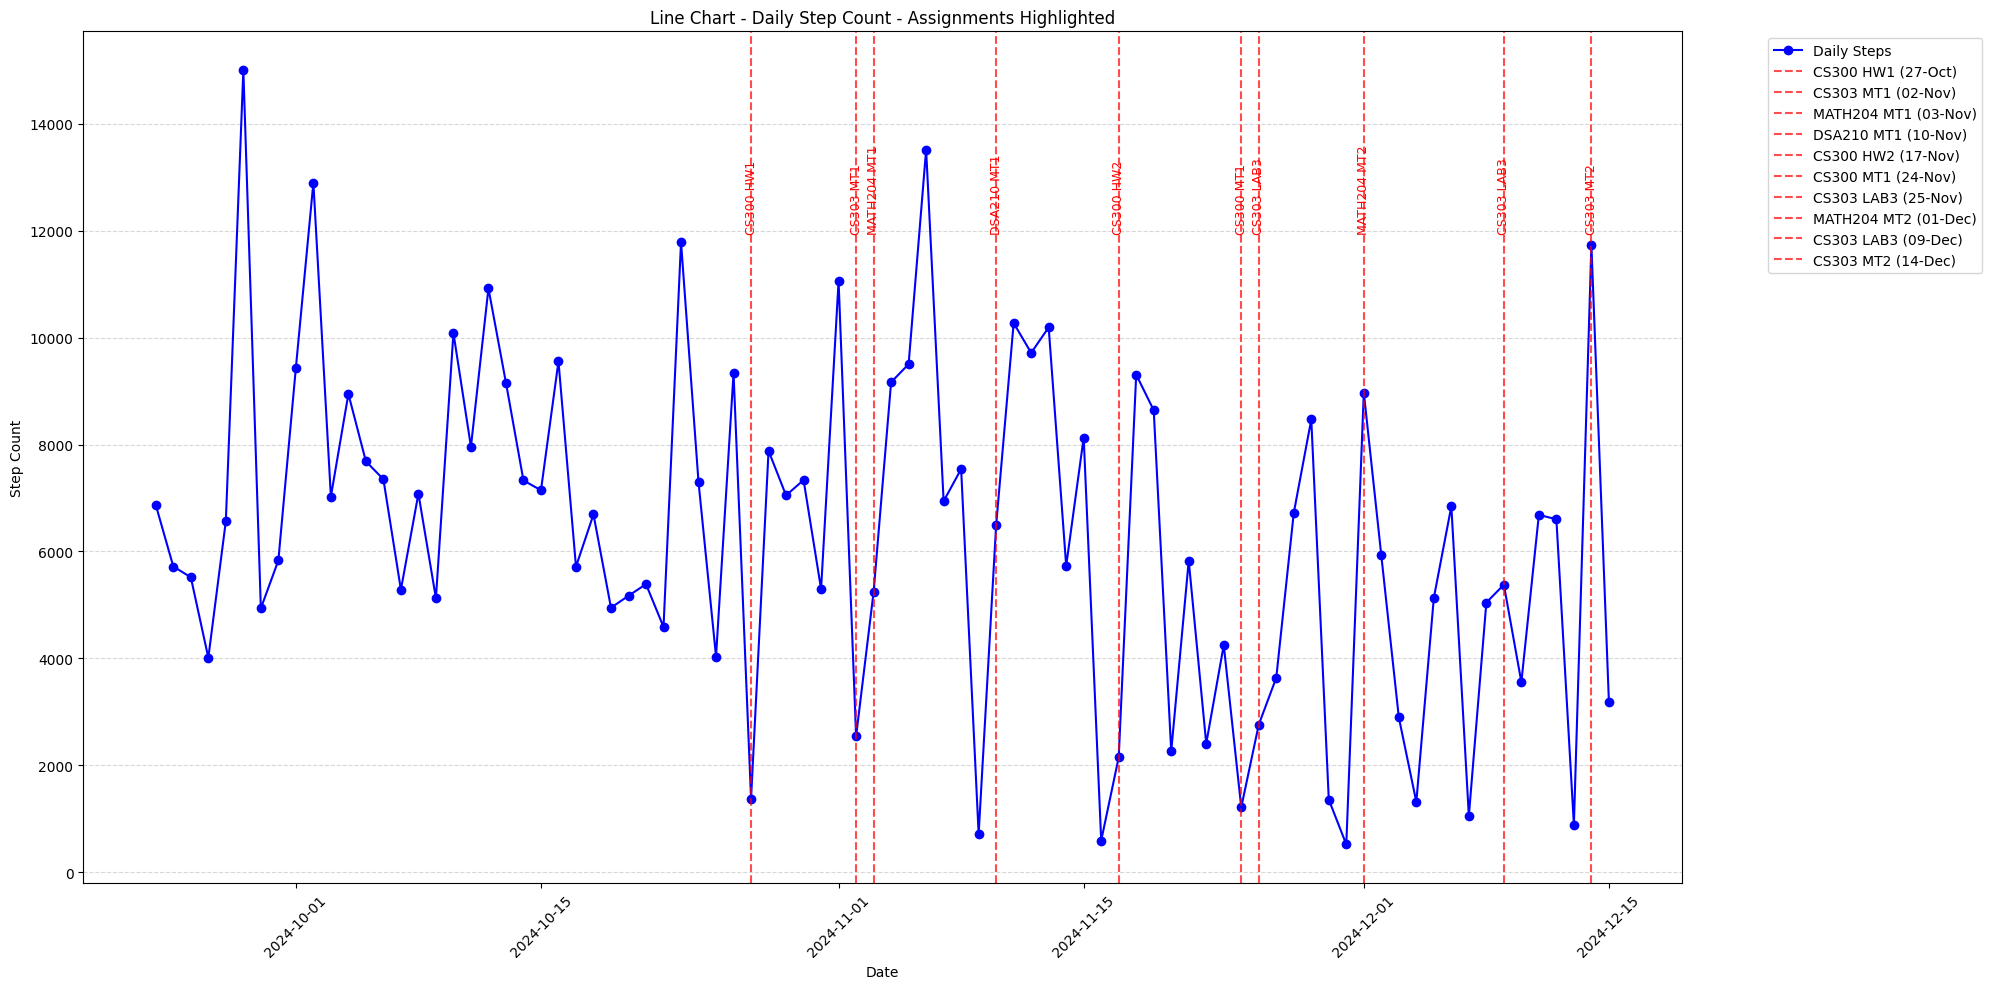

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Load and Prepare Data
# Assuming df_pivot_health contains data parsed from export.xml
# Ensure the Date column is in datetime format
df_pivot_health["Date"] = pd.to_datetime(df_pivot_health["Date"])

# Filter data to start from October 2024
df_pivot_health = df_pivot_health[df_pivot_health["Date"] >= "2024-9-23"]

# Aggregate daily step counts
daily_health_summary = df_pivot_health.groupby("Date")[["Steps"]].sum().reset_index()

# Step 2: Define Events
events = [
    {"name": "CS300 HW1", "date": "2024-10-27"},
    {"name": "CS303 MT1", "date": "2024-11-02"},
    {"name": "MATH204 MT1", "date": "2024-11-03"},
    {"name": "DSA210 MT1", "date": "2024-11-10"},
    {"name": "CS300 HW2", "date": "2024-11-17"},
    {"name": "CS300 MT1", "date": "2024-11-24"},
    {"name": "CS303 LAB3", "date": "2024-11-25"},
    {"name": "MATH204 MT2", "date": "2024-12-01"},
    {"name": "CS303 LAB3", "date": "2024-12-09"},
    {"name": "CS303 MT2", "date": "2024-12-14"},
]
event_dates = pd.to_datetime([event["date"] for event in events])
event_names = [event["name"] for event in events]

# Step 3: Plot Data
plt.figure(figsize=(20, 10))

# Plot daily step counts
plt.plot(daily_health_summary["Date"], daily_health_summary["Steps"], marker="o", label="Daily Steps", color="blue")

# Highlight task dates with vertical lines and annotations
for date, name in zip(event_dates, event_names):
    if date >= pd.to_datetime("2024-10-01"):  # Only annotate events from October
        plt.axvline(date, color="red", linestyle="--", alpha=0.7, label=f"{name} ({date.strftime('%d-%b')})")
        plt.text(date, daily_health_summary["Steps"].max() * 0.8, name, rotation=90, color="red", fontsize=9, ha="center")

# Customize plot
plt.title("Line Chart - Daily Step Count - Assignments Highlighted")
plt.xlabel("Date")
plt.ylabel("Step Count")
plt.xticks(rotation=45)
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()




# **Explanation of Bar Plot with Assignment Highlights**

This script generates a bar plot to visualize daily step counts while highlighting task days with colors and annotations.

---

## **1. Data Preparation**

### **Ensuring Date Format**
- The `Date` column in `daily_health_summary` is converted to a datetime type for proper handling.

### **Task Day Identification**
- Task days are flagged using the `event_dates` list, creating a new `TaskImpact` column:
  - `True` if the date corresponds to a task.
  - `False` otherwise.

### **Assignment Status Mapping**
- The `TaskImpact` column is mapped to "Existing" (for task days) and "Missing" (for non-task days) in a new `Assignment` column.

---

## **2. Visualizing the Data**

### **Bar Plot**
- A bar plot is created using Seaborn to display:
  - `Date` on the x-axis (converted to string for better readability).
  - `Steps` on the y-axis.
  - Bars colored based on the `Assignment` status:
    - Red for task days.
    - Blue for non-task days.

---

## **3. Highlighting Task Dates**

### **Vertical Lines**
- Vertical dashed lines (`axvline`) are added for each task date starting from October 1, 2024.

### **Annotations**
- Task names are annotated above the corresponding vertical lines at 80% of the maximum step count.

---

## **4. Customizing the Plot**

### **Title and Axes**
- The plot is titled "Bar Plot - Daily Step Count - Assignments Highlighted."
- X-axis: Dates, rotated for clarity.
- Y-axis: Step counts.

### **Grid Lines**
- Horizontal grid lines are added to enhance readability.

### **Layout Adjustment**
- `plt.tight_layout()` ensures no overlap of plot elements.

---

## **Purpose of the Visualization**
This plot provides a clear visual representation of daily activity levels, distinguishing task and non-task days and highlighting the impact of assignments.


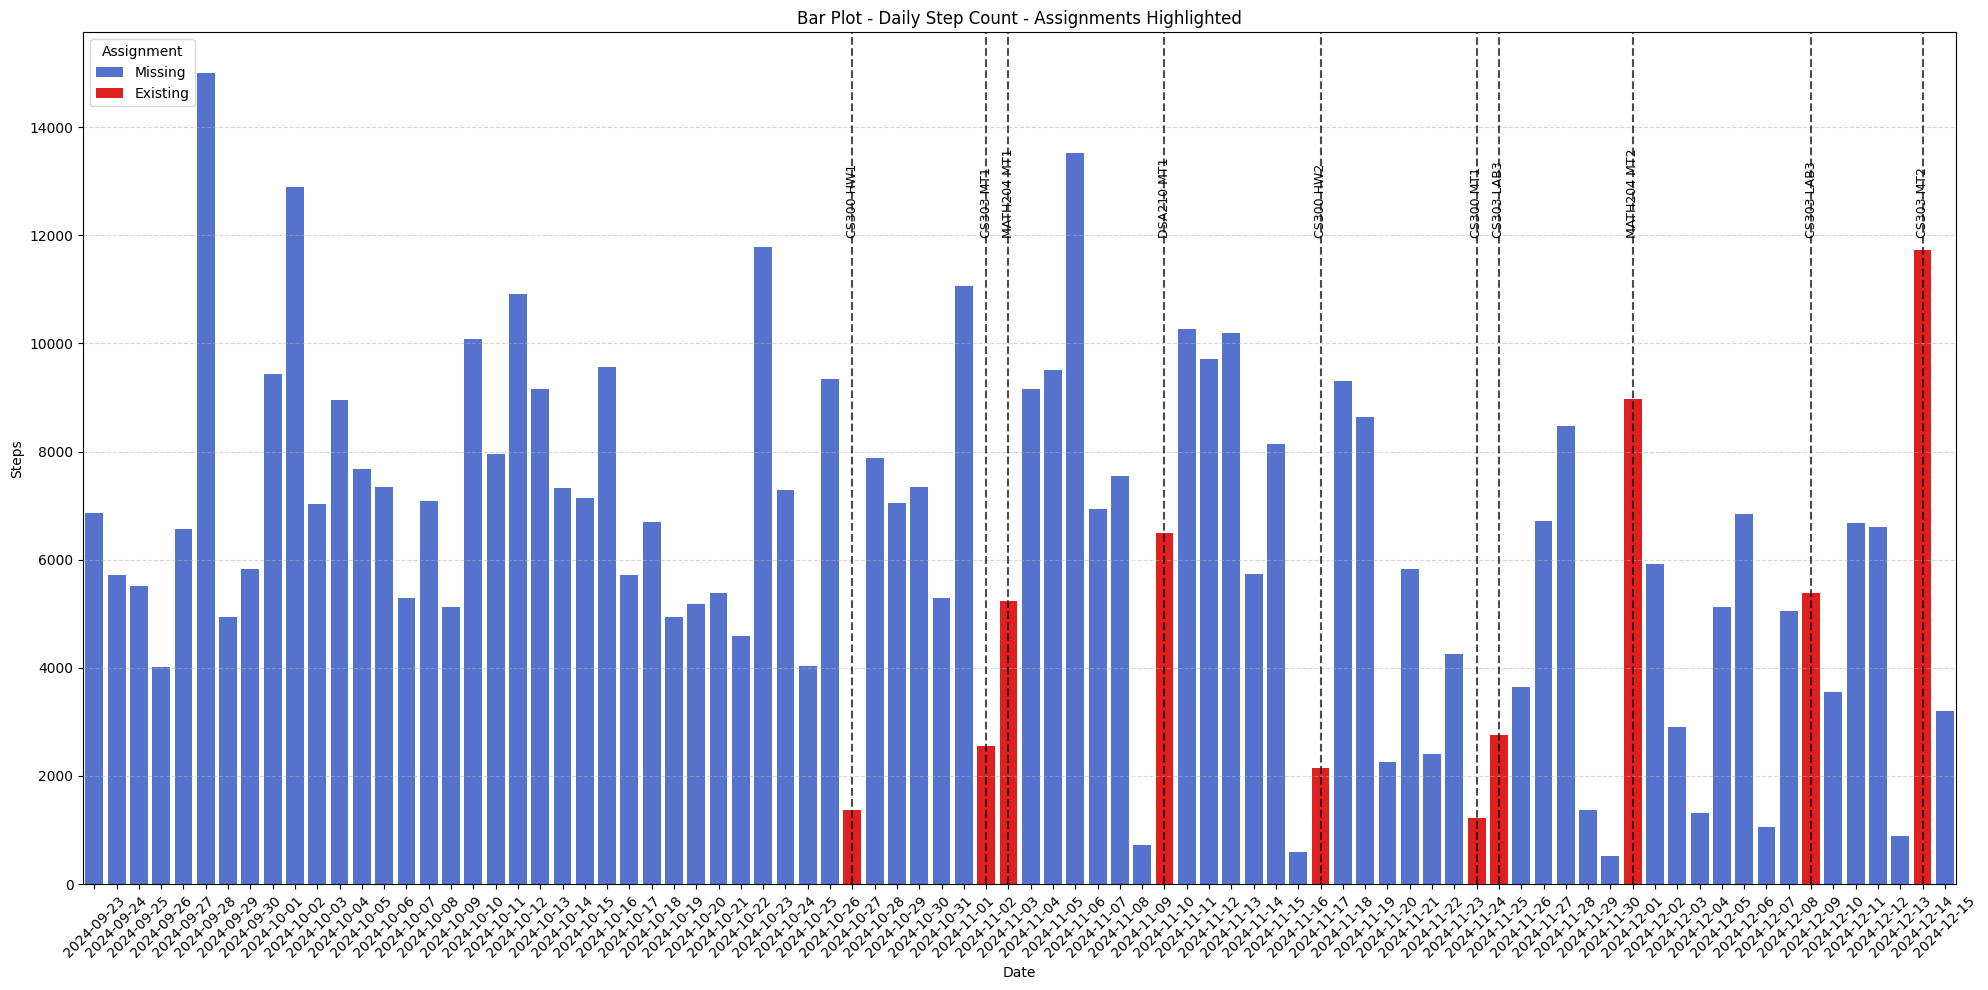

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure 'Date' is datetime type
daily_health_summary["Date"] = pd.to_datetime(daily_health_summary["Date"])

# Highlight task days
daily_health_summary["TaskImpact"] = daily_health_summary["Date"].isin(event_dates)

# Map True/False to "Existing" and "Missing"
daily_health_summary["Assignment"] = daily_health_summary["TaskImpact"].map({True: "Existing", False: "Missing"})

# Plot the data
plt.figure(figsize=(20, 10))

# Plot the data
sns.barplot(
    data=daily_health_summary,
    x=daily_health_summary["Date"].dt.strftime("%Y-%m-%d"),  # Convert Date to string for the x-axis
    y="Steps",
    hue="Assignment",
    dodge=False,
    palette={"Existing": "red", "Missing": "royalblue"}
)

# Add vertical lines and annotations for tasks
for date, name in zip(event_dates, event_names):
    if date >= pd.Timestamp("2024-10-01"):
        plt.axvline(date.strftime("%Y-%m-%d"), color="black", linestyle="--", alpha=0.7)
        plt.text(date.strftime("%Y-%m-%d"), daily_health_summary["Steps"].max() * 0.8, name,
                 rotation=90, color="black", fontsize=9, ha="center")

# Customize plot
plt.title("Bar Plot - Daily Step Count - Assignments Highlighted")
plt.xlabel("Date")
plt.ylabel("Steps")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()

plt.show()


# **Explanation of Heatmap with Task Annotations**

This script creates a heatmap to visualize daily step counts across weeks and days, while annotating task-related data.

---

## **1. Data Preparation**

### **Copying Data**
- A copy of the `daily_health_summary` DataFrame is created for modifications.

### **Adding Week and Day Columns**
- `Week`: Extracted from the `Date` column using `isocalendar().week` to group data by calendar weeks.
- `Day`: Extracted as the day of the week from the `Date` column. The days are ordered Monday through Sunday using `pd.Categorical`.

---

## **2. Week Interval Mapping**

### **Grouping by Week**
- The data is grouped by week to calculate the start (`min`) and end (`max`) dates for each week.

### **Creating Interval Labels**
- Week intervals are created in the format "MMM DD - MMM DD" (e.g., "Oct 01 - Oct 07") for easier interpretation on the x-axis.

### **Dictionary Conversion**
- A dictionary maps week numbers to their respective date intervals for x-axis labeling.

---

## **3. Data Transformation for Heatmap**

### **Pivoting Data**
- The data is pivoted into a matrix:
  - Index: Days of the week (Monday to Sunday).
  - Columns: Week numbers.
  - Values: Daily step counts.

### **Task Annotations**
- A `TaskImpact` column flags whether a date corresponds to a task (`True`) or not (`False`).
- `event_dates` are converted to a list for indexing.

---

## **4. Creating the Heatmap**

### **Heatmap Design**
- Seaborn's `heatmap` is used to plot:
  - `heatmap_pivot` as the data source.
  - `coolwarm` colormap for visual appeal.
  - Step counts annotated within the cells.

### **X-Axis Labels**
- Week intervals replace week numbers on the x-axis for better readability.

---

## **5. Highlighting Task Days**

### **Adding Borders**
- Task days are identified, and black rectangular borders are added around their corresponding cells.

### **Star and Task Name Annotations**
- A red star (`*`) is placed in the center of the task day's cell.
- Task names are annotated slightly below the star for additional context.

---

## **6. Customizing the Plot**

### **Title and Axes**
- Title: "Heatmap - Daily Step Counts - Assignments Highlighted."
- X-axis: Week intervals.
- Y-axis: Days of the week.

### **Layout Adjustment**
- `plt.tight_layout()` ensures proper spacing between elements to avoid overlaps.

---

## **Purpose of the Visualization**
This heatmap provides an intuitive way to observe patterns in step counts across weeks and days, while clearly marking task days with annotations and visual highlights.


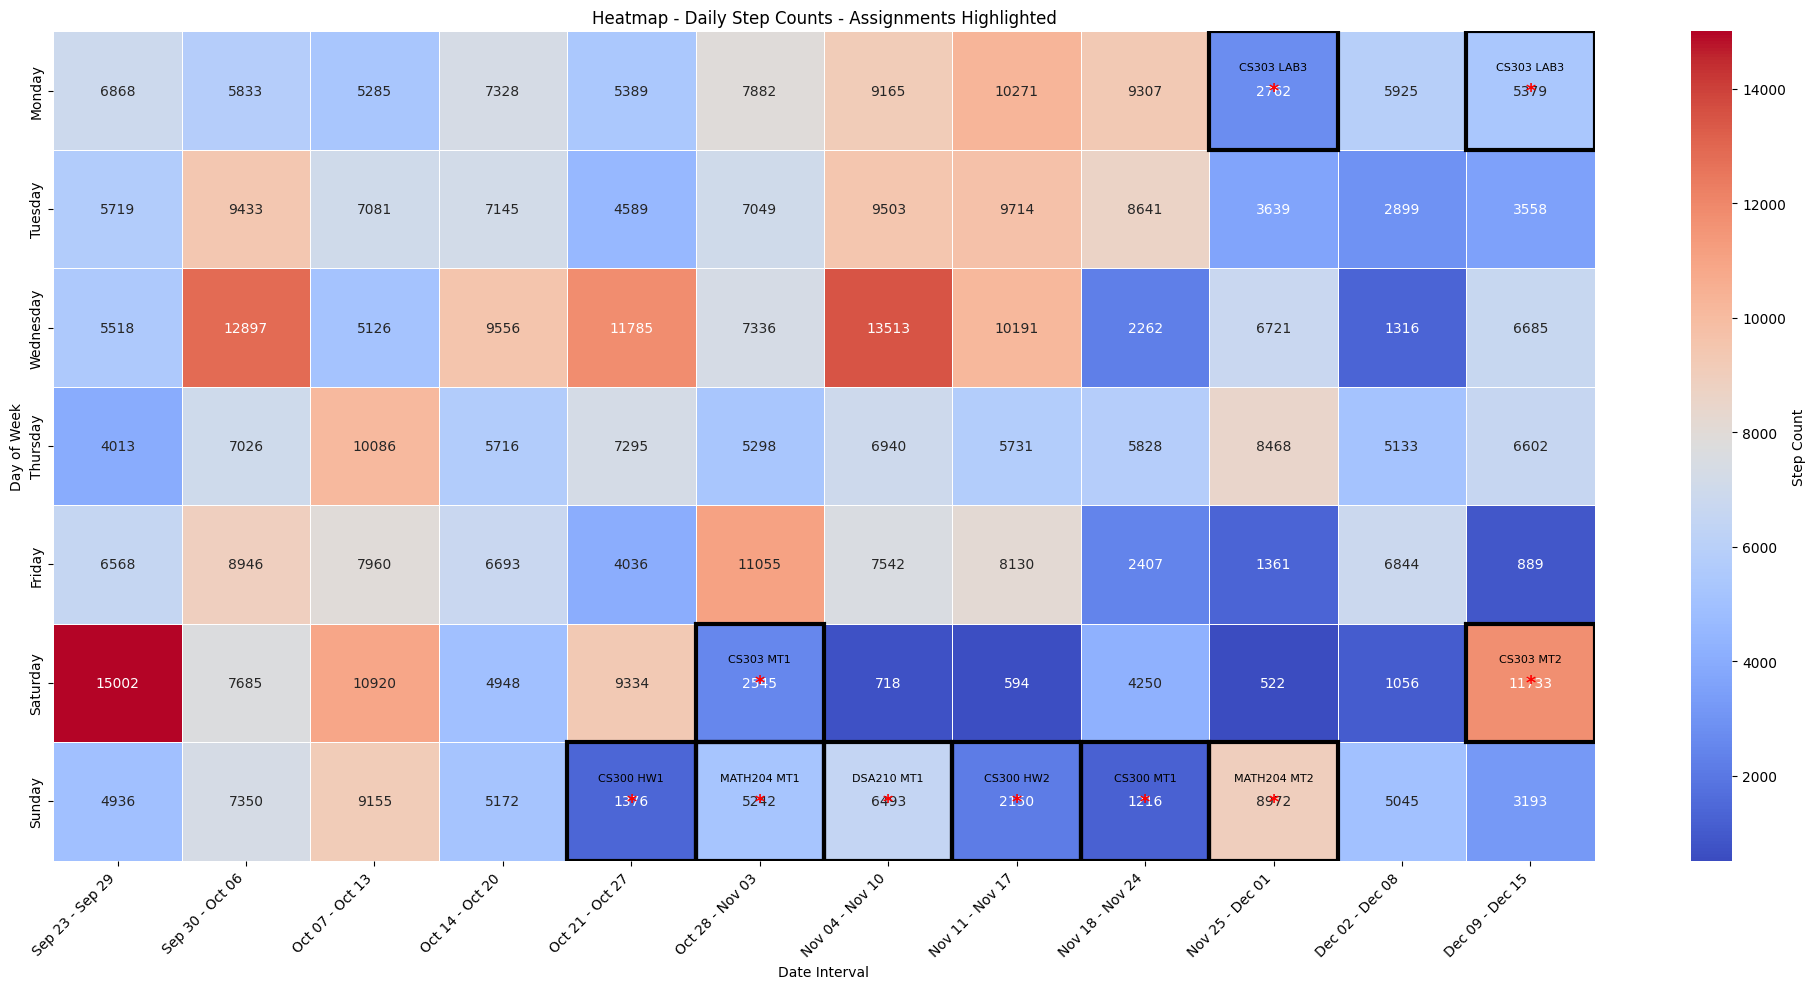

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Enhance the heatmap with task annotations
heatmap_data = daily_health_summary.copy()
heatmap_data["Week"] = heatmap_data["Date"].dt.isocalendar().week
heatmap_data["Day"] = pd.Categorical(
    heatmap_data["Date"].dt.day_name(),
    categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
    ordered=True
)

# Create a mapping of week numbers to date intervals
week_to_dates = heatmap_data.groupby("Week")["Date"].agg(["min", "max"])
week_to_dates["Interval"] = week_to_dates["min"].dt.strftime("%b %d") + " - " + week_to_dates["max"].dt.strftime("%b %d")
week_to_dates_dict = week_to_dates["Interval"].to_dict()

# Pivot data for the heatmap
heatmap_pivot = heatmap_data.pivot(index="Day", columns="Week", values="Steps")

# Task annotations: Add a flag for task days
heatmap_data["TaskImpact"] = heatmap_data["Date"].isin(event_dates)

# Convert event_dates to a list for indexing
event_dates_list = list(event_dates)

# Create the heatmap
plt.figure(figsize=(20, 10))
ax = sns.heatmap(
    heatmap_pivot,
    cmap="coolwarm",
    annot=True,
    fmt=".0f",
    linewidths=0.5,
    cbar_kws={"label": "Step Count"}
)

# Update x-axis labels with date intervals
ax.set_xticklabels([week_to_dates_dict[week] for week in heatmap_pivot.columns], rotation=45, ha="right")

# Overlay task days on the heatmap
for _, row in heatmap_data[heatmap_data["TaskImpact"]].iterrows():
    week = row["Week"]
    day = row["Day"]
    steps = row["Steps"]
    # Find the task name for the given date
    task_name = event_names[event_dates_list.index(row["Date"])]
    
    # Highlight the task day with a border
    day_idx = list(heatmap_pivot.index).index(day)
    week_idx = list(heatmap_pivot.columns).index(week)
    
    ax.add_patch(plt.Rectangle((week_idx, day_idx), 1, 1, fill=False, edgecolor="black", lw=3))
    
    # Add star and task name within the square
    ax.text(
        week_idx + 0.5, day_idx + 0.5, "*",
        color="red", fontsize=14, ha="center", va="center", fontweight="bold"
    )
    ax.text(
        week_idx + 0.5, day_idx + 0.3, task_name,
        color="black", fontsize=8, ha="center", va="center", wrap=True
    )

# Add title and labels
plt.title("Heatmap - Daily Step Counts - Assignments Highlighted")
plt.xlabel("Date Interval")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()


# **Explanation of Stacked Area Chart with Assignment Highlights**

This script generates a stacked area chart to visualize step counts over time, with task dates highlighted for better analysis.

---

## **1. Setting Up the Figure**

### **Figure Dimensions**
- `plt.figure(figsize=(20, 10))`: Initializes a large figure with a width of 20 and height of 10 for better readability.

---

## **2. Plotting the Stacked Area Chart**

### **Using `fill_between`**
- The `fill_between` function is used to create the stacked area chart:
  - `x`: Dates from the `daily_health_summary["Date"]` column.
  - `y`: Corresponding step counts from `daily_health_summary["Steps"]`.
  - `color`: Set to "teal" for a visually appealing shade.
  - `alpha`: Set to `0.5` to make the area semi-transparent.
  - `label`: The area is labeled as "Steps."

This visualization emphasizes the cumulative nature of the step counts over time.

---

## **3. Highlighting Assignment Dates**

### **Adding Vertical Lines**
- For each task in `event_dates`:
  - A vertical dashed line is drawn using `plt.axvline` to mark the task date.
  - Red color (`color="red"`) and semi-transparency (`alpha=0.7`) are used for visibility.

### **Annotating Task Names**
- Task names from `event_names` are displayed above their respective task dates using `plt.text`:
  - Positioned slightly below the maximum step count (`daily_health_summary["Steps"].max() * 0.8`).
  - Rotated vertically (`rotation=90`) for compact labeling.
  - Font size and color are set for readability.

---

## **4. Customizing the Plot**

### **Titles and Axes**
- Title: "Stacked Area Chart - Assignments Highlighted."
- X-axis: Date labels rotated for clarity (`plt.xticks(rotation=45)`).
- Y-axis: Step count values.

### **Legend**
- A legend is added in the upper left corner (`loc="upper left"`) and positioned outside the plot (`bbox_to_anchor=(1.05, 1)`).

### **Grid Lines**
- Horizontal grid lines are added along the Y-axis for better value tracking (`plt.grid(axis="y", linestyle="--", alpha=0.5)`).

### **Layout**
- `plt.tight_layout()` ensures that plot elements fit neatly without overlapping.

---

## **Purpose of the Visualization**

This stacked area chart provides a clear depiction of daily step count trends over time. By overlaying task dates with annotations and vertical lines, it visually connects assignments with fluctuations in activity, making it easier to analyze the impact of assignments on step counts.


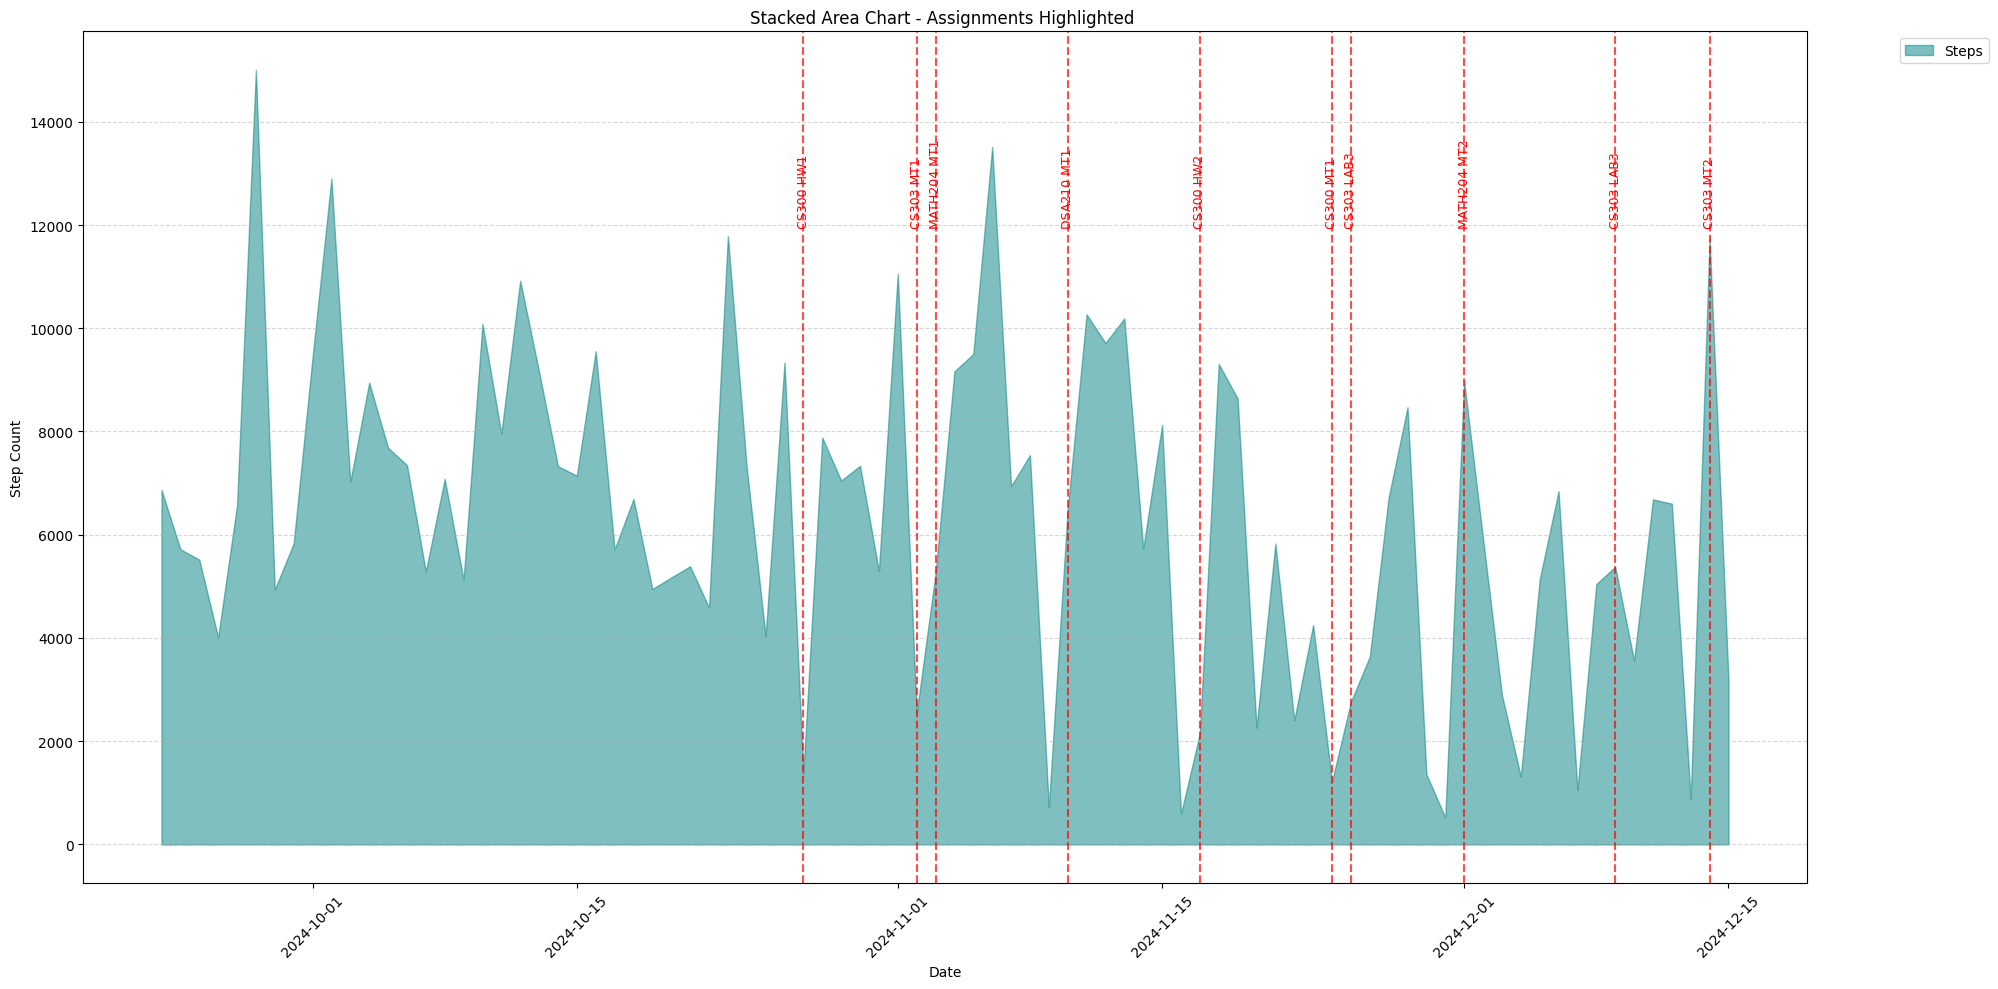

In [7]:
plt.figure(figsize=(20, 10))

# Plot stacked area chart
plt.fill_between(
    daily_health_summary["Date"],
    daily_health_summary["Steps"],
    color="teal",
    alpha=0.5,
    label="Steps"
)

# Add vertical lines and annotations for tasks
for date, name in zip(event_dates, event_names):
    if date >= pd.Timestamp("2024-10-01"):
        plt.axvline(date, color="red", linestyle="--", alpha=0.7)
        plt.text(date, daily_health_summary["Steps"].max() * 0.8, name, rotation=90, color="red", fontsize=9, ha="center")

# Customize
plt.title("Stacked Area Chart - Assignments Highlighted ")
plt.xlabel("Date")
plt.ylabel("Step Count")
plt.xticks(rotation=45)
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()

plt.show()


# **Explanation of Bubble Chart - Step Counts with Assignments Highlighted**

This script generates a bubble chart to visualize step counts over time, with task days highlighted using larger, differently colored bubbles.

---

## **1. Preparing Data for Visualization**

### **Ensure Task Dates Are Usable**
- `event_dates_list = list(event_dates)`: Converts `event_dates` to a list to allow indexing.

### **Adding Key Columns**
1. **Task Impact**:
   - `daily_health_summary["TaskImpact"]`: A boolean column indicating whether a date is a task day.
   - Uses `daily_health_summary["Date"].isin(event_dates)` to mark task dates as `True` and others as `False`.

2. **Bubble Size**:
   - `daily_health_summary["BubbleSize"]`: Sets bubble size based on task impact.
   - Task days (`True`) have a size of `100`, while non-task days (`False`) have a size of `20`.

3. **Bubble Color**:
   - `daily_health_summary["Color"]`: Assigns bubble colors based on task impact.
   - Task days are colored "red," and non-task days are colored "blue."

---

## **2. Creating the Scatter Plot**

### **Plot Customization**
- `plt.scatter` is used to plot:
  - `x`: Date values (`daily_health_summary["Date"]`).
  - `y`: Step counts (`daily_health_summary["Steps"]`).
  - `s`: Bubble size (`daily_health_summary["BubbleSize"]`).
  - `c`: Bubble color (`daily_health_summary["Color"]`).
  - `alpha`: Transparency is set to `0.6` for a balanced view.
  - `label`: A legend entry describing the color coding.

---

## **3. Annotating Task Days**

### **Adding Text Labels**
- For each task day (`daily_health_summary["TaskImpact"] == True`):
  - Labels are added using `plt.text`.
  - Positioned slightly above the bubble (`row["Steps"] + 500`).
  - Displays the corresponding task name (`event_names[event_dates_list.index(row["Date"])]`).
  - Formatting includes bold black text for readability.

---

## **4. Enhancing the Visualization**

### **Titles and Axes**
- `plt.title`: Adds a descriptive title to the chart.
- `plt.xlabel` and `plt.ylabel`: Label the x-axis (Date) and y-axis (Steps).
- `plt.xticks(rotation=45)` and `plt.yticks`: Adjust tick formatting for readability.

### **Legend and Grid**
- `plt.legend`: Displays a legend explaining the color coding for task and non-task days.
- `plt.grid(axis="y", linestyle="--", alpha=0.5)`: Adds horizontal grid lines for better visual guidance.

### **Tight Layout**
- `plt.tight_layout`: Ensures plot elements fit neatly within the figure.

---

## **Purpose of the Visualization**

This bubble chart effectively highlights the relationship between daily steps and task days. The size and color of the bubbles draw attention to task days, making it easier to analyze how step counts vary around these dates.


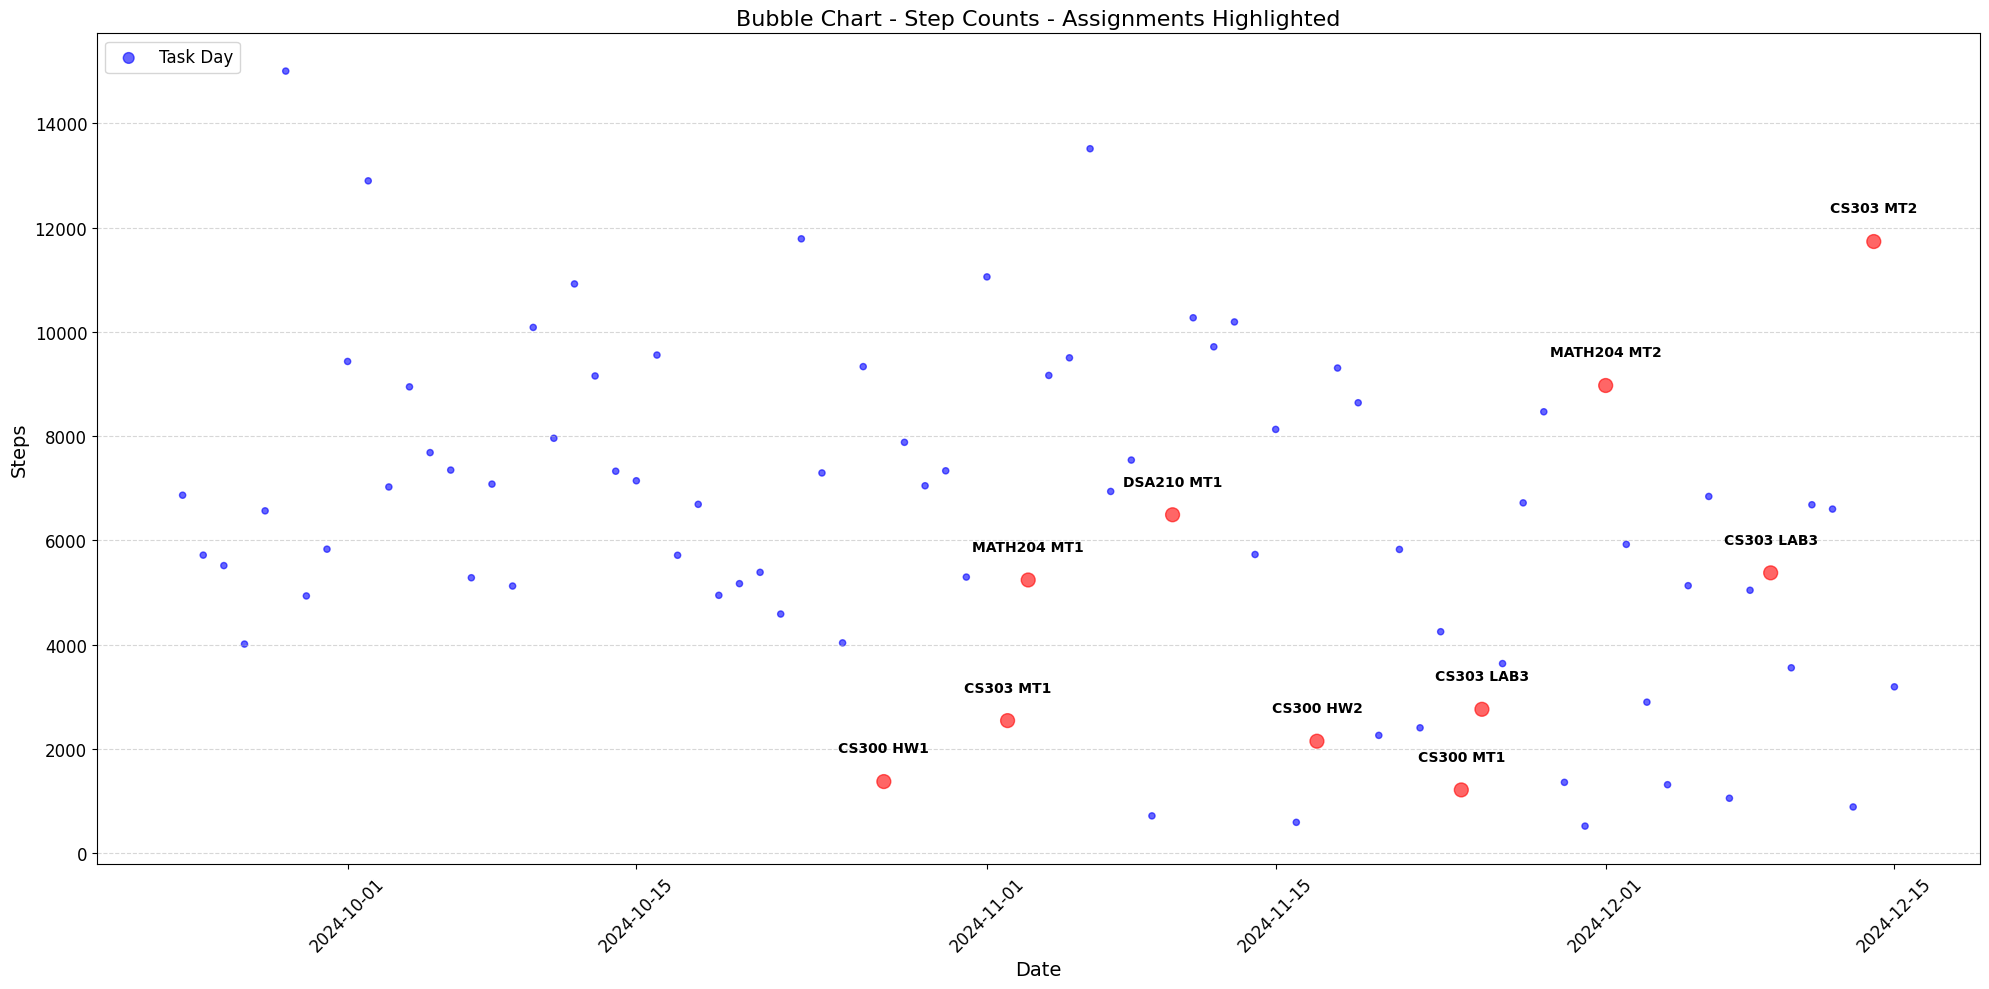

In [8]:
# Ensure `event_dates` is a list for indexing
event_dates_list = list(event_dates)

# Create 'TaskImpact', 'BubbleSize', and 'Color' columns
daily_health_summary["TaskImpact"] = daily_health_summary["Date"].isin(event_dates)
daily_health_summary["BubbleSize"] = daily_health_summary["TaskImpact"].apply(lambda x: 100 if x else 20)
daily_health_summary["Color"] = daily_health_summary["TaskImpact"].apply(lambda x: "red" if x else "blue")

plt.figure(figsize=(20, 10))

# Plot the scatter plot
plt.scatter(
    daily_health_summary["Date"],
    daily_health_summary["Steps"],
    s=daily_health_summary["BubbleSize"],
    c=daily_health_summary["Color"],
    alpha=0.6,
    label="Task Day (Red) / Non-Task Day (Blue)"
)

# Add labels for task days
for i, row in daily_health_summary[daily_health_summary["TaskImpact"]].iterrows():
    plt.text(
        row["Date"], row["Steps"] + 500,  # Position label slightly above the bubble
        event_names[event_dates_list.index(row["Date"])],
        fontsize=10, ha="center", va="bottom", color="black", weight="bold"
    )

# Add titles and labels
plt.title("Bubble Chart - Step Counts - Assignments Highlighted", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Steps", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add grid and legend
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend(["Task Day", "Non-Task Day"], loc="upper left", fontsize=12)

plt.tight_layout()
plt.show()


# **Explanation of Step Count Comparison: Before and After Task Days**

This script compares the average step counts of the two days before and after each task day. It then visualizes these comparisons in a bar chart, highlighting the changes in activity levels.

---

## **1. Data Preparation**

### **Looping Through Task Dates**
- The script iterates over `event_dates` (list of task dates):
  - **Before Steps**: Calculates the mean step count for the two days preceding the task date:
    - `daily_health_summary[daily_health_summary["Date"] < event_date].tail(2)["Steps"].mean()`
    - Filters dates earlier than the task date and takes the last two entries.
  - **After Steps**: Calculates the mean step count for the two days following the task date:
    - `daily_health_summary[daily_health_summary["Date"] > event_date].head(2)["Steps"].mean()`
    - Filters dates later than the task date and takes the first two entries.

### **Adding Task Names**
- `event_name`: Retrieves the name of the task associated with the task date:
  - Uses `event_names[event_dates_list.index(event_date)]` to match the task name.

### **Appending Data**
- For each task day, the script appends a dictionary containing:
  - `Event`: Name of the task.
  - `Before`: Average steps for the two days before the task.
  - `After`: Average steps for the two days after the task.
- Appended to the list `impact_data`.

---

## **2. Creating a DataFrame**

- Converts `impact_data` into a Pandas DataFrame `impact_df`:
  - Contains columns: `Event`, `Before`, and `After`.

---

## **3. Visualizing the Comparison**

### **Bar Chart**
- `impact_df.set_index("Event")[["Before", "After"]].plot(kind="bar")`:
  - Sets `Event` as the index for easy grouping.
  - Plots the `Before` and `After` columns as a bar chart.
  - Groups bars by task names for a side-by-side comparison.

### **Customization**
- `plt.title`: Adds a title to the chart.
- `plt.xlabel` and `plt.ylabel`: Labels the x-axis (Event) and y-axis (Average Steps of 2 Days).
- `plt.tight_layout`: Adjusts layout to ensure all elements fit neatly.

---

## **Purpose of the Visualization**

This bar chart provides a clear visual representation of how step counts change in the days immediately surrounding task days. It allows for easy comparison of activity levels before and after tasks, helping to identify patterns and validate hypotheses about the impact of task days on daily activity.


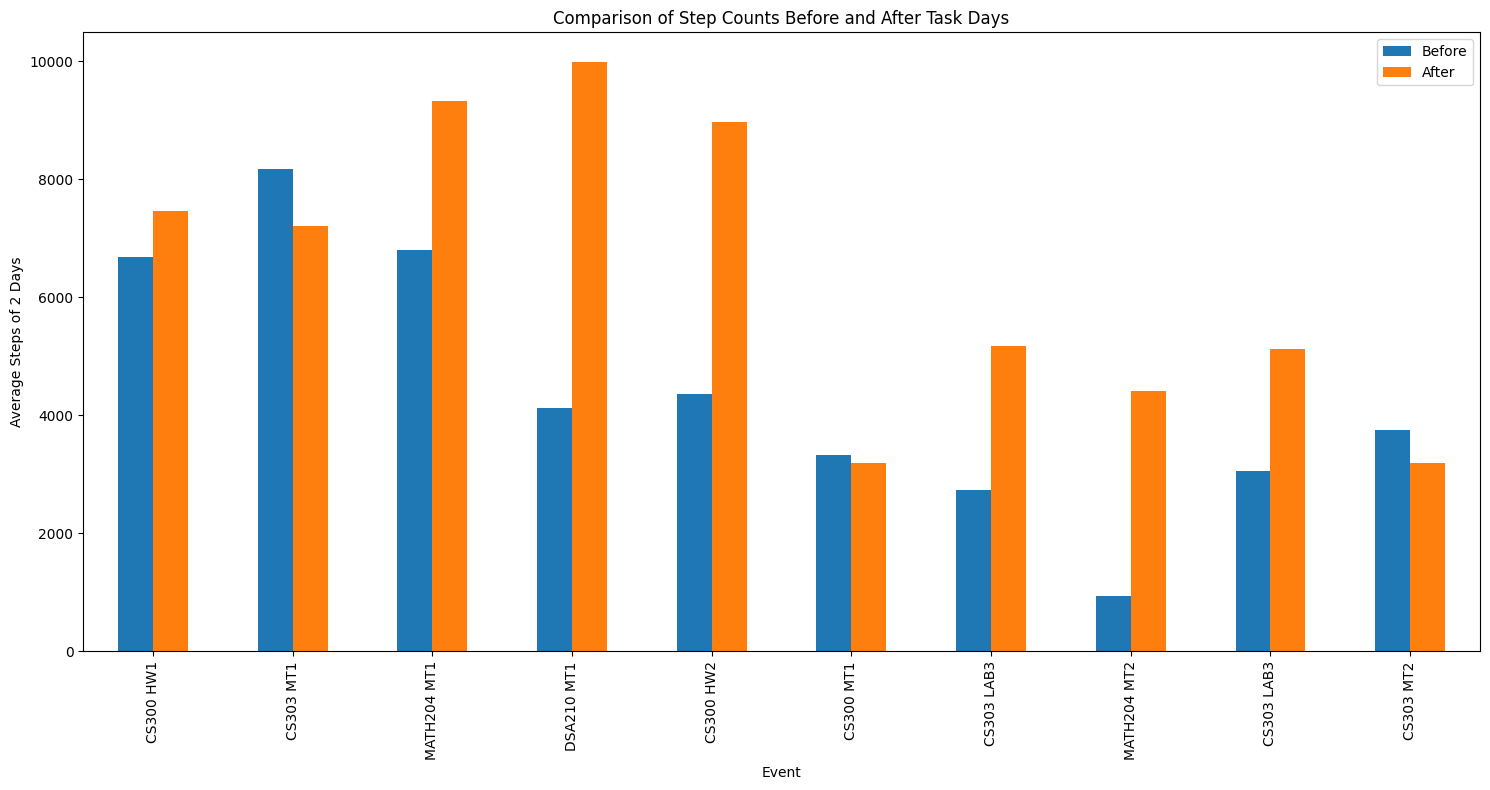

In [9]:
impact_data = []

# Convert event_dates to a list for indexing
event_dates_list = list(event_dates)

for event_date in event_dates:
    # Calculate average steps before and after the event date
    before_steps = daily_health_summary[daily_health_summary["Date"] < event_date].tail(2)["Steps"].mean()
    after_steps = daily_health_summary[daily_health_summary["Date"] > event_date].head(2)["Steps"].mean()
    
    # Find the event name using the list version of event_dates
    event_name = event_names[event_dates_list.index(event_date)]
    impact_data.append({"Event": event_name, "Before": before_steps, "After": after_steps})

# Create a DataFrame for impact data
impact_df = pd.DataFrame(impact_data)

# Plot the comparison
impact_df.set_index("Event")[["Before", "After"]].plot(kind="bar", figsize=(15, 8))
plt.title("Comparison of Step Counts Before and After Task Days")
plt.xlabel("Event")
plt.ylabel("Average Steps of 2 Days")
plt.tight_layout()
plt.show()


# **Explanation of Cumulative Steps Over Time Visualization**

This script generates a line chart to display cumulative step counts over time, while highlighting specific task days. It provides insights into the progression of physical activity as task days approach.

---

## **1. Calculating Cumulative Steps**

### **Adding a `CumulativeSteps` Column**
- `daily_health_summary["CumulativeSteps"] = daily_health_summary["Steps"].cumsum()`:
  - Computes the cumulative sum of daily steps using the `cumsum()` method.
  - The resulting column tracks the total steps taken up to each date.

---

## **2. Visualizing Cumulative Steps**

### **Line Chart**
- `plt.plot(daily_health_summary["Date"], daily_health_summary["CumulativeSteps"])`:
  - Plots the cumulative steps against dates.
  - Sets the line color to `green` and increases the thickness using `linewidth=4` for better visibility.

---

## **3. Highlighting Task Days**

### **Vertical Lines for Task Days**
- `plt.axvline(date, color="red", linestyle="--", alpha=0.7)`:
  - Adds a dashed vertical red line at each task date (`event_dates`) for easy identification.

### **Adding Task Labels**
- `plt.text()`:
  - Positions task labels slightly below the maximum cumulative step value (80% of max).
  - Labels include task names (`event_names`) with vertical rotation for readability.
  - Font color is set to red to match the vertical lines.

---

## **4. Chart Customization**

### **Title and Axis Labels**
- `plt.title`: Adds a title to describe the chart.
- `plt.xlabel` and `plt.ylabel`: Label the x-axis as "Date" and the y-axis as "Cumulative Steps."

### **Formatting**
- `plt.xticks(rotation=45)`: Rotates x-axis labels for better readability.
- `plt.grid(axis="y")`: Adds dashed gridlines along the y-axis for visual clarity.

---

## **Purpose of the Visualization**

This cumulative step chart provides a clear overview of how activity levels accumulate over time. By highlighting task days, it allows for the identification of trends or anomalies in activity patterns surrounding assignments. The visualization serves as evidence to support hypotheses regarding the relationship between task days and physical activity.


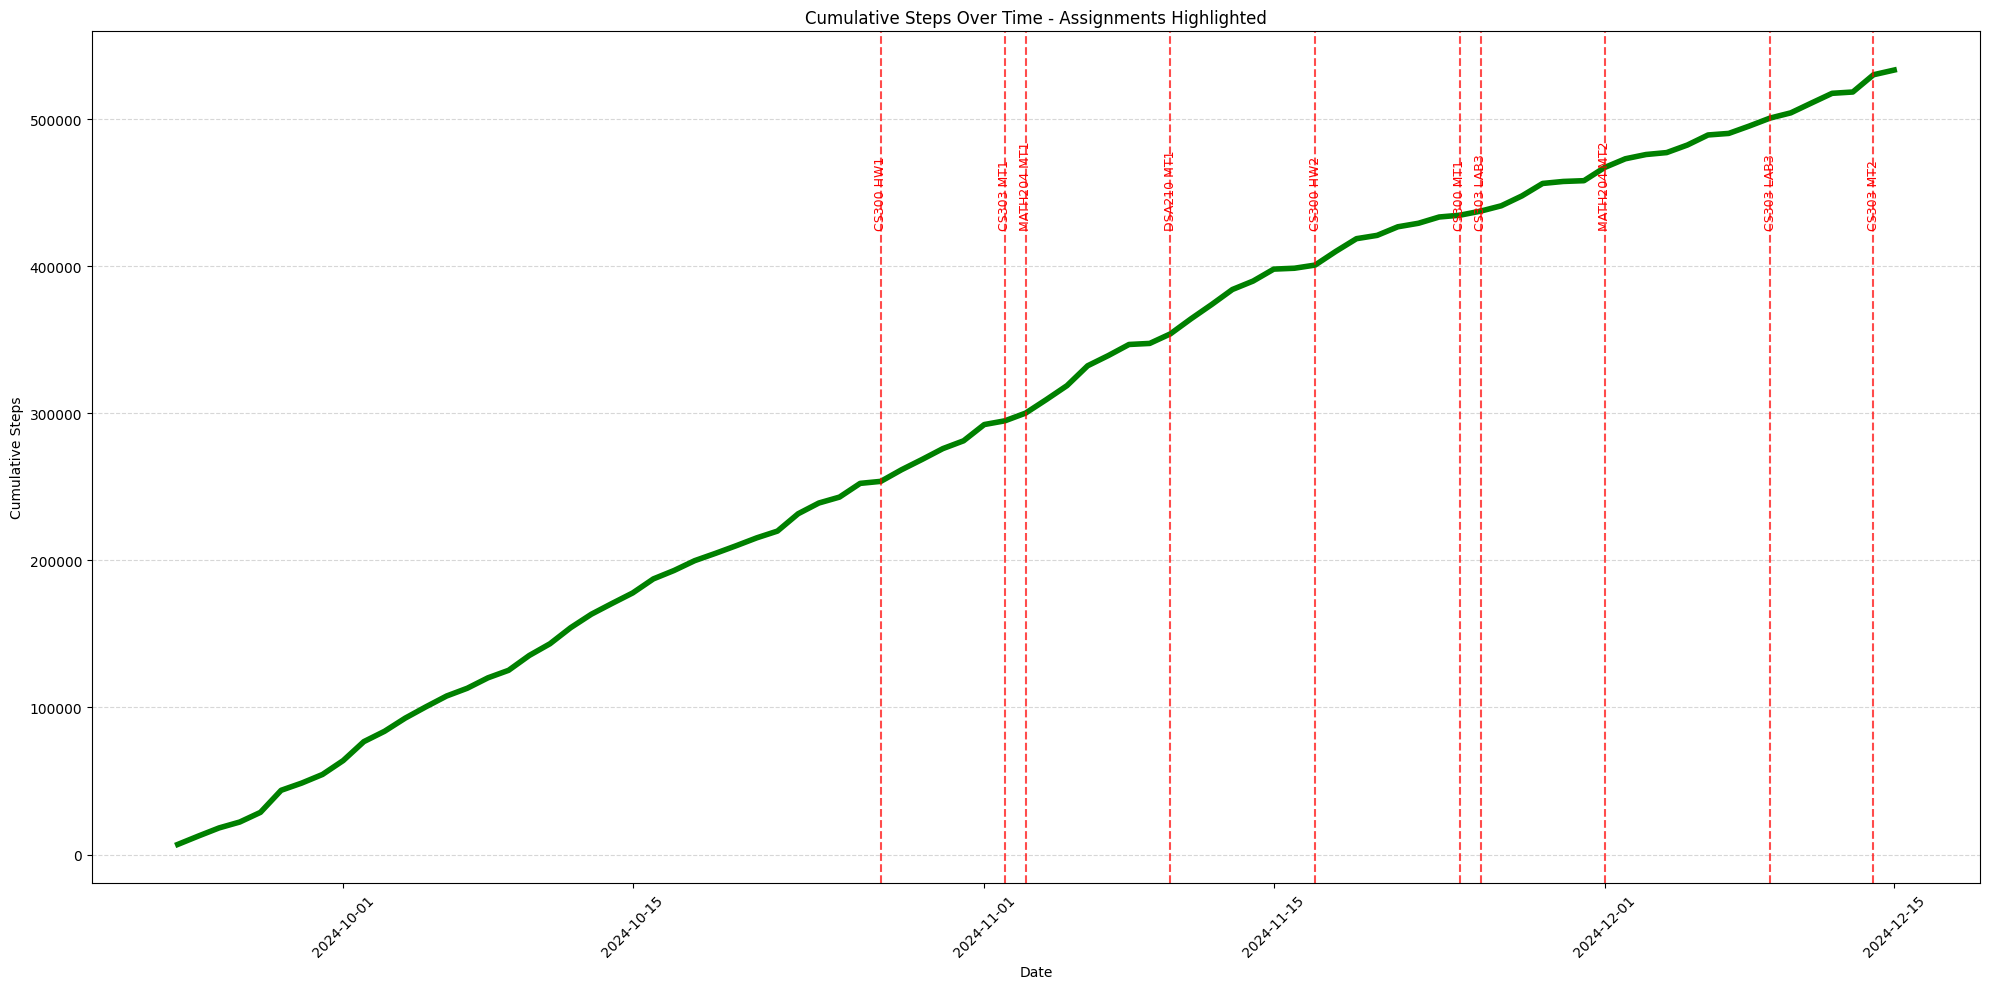

In [10]:
daily_health_summary["CumulativeSteps"] = daily_health_summary["Steps"].cumsum()

plt.figure(figsize=(20, 10))
plt.plot(daily_health_summary["Date"], daily_health_summary["CumulativeSteps"], label="Cumulative Steps", color="green", linewidth=4)  # Adjusted linewidth

# Mark task days
for date, name in zip(event_dates, event_names):
    plt.axvline(date, color="red", linestyle="--", alpha=0.7)
    plt.text(date, daily_health_summary["CumulativeSteps"].max() * 0.8, name, rotation=90, color="red", fontsize=9, ha="center")

plt.title("Cumulative Steps Over Time - Assignments Highlighted")
plt.xlabel("Date")
plt.ylabel("Cumulative Steps")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


# **Explanation of Heatmap for Total Steps Before and After Assignments**

This script generates a heatmap to visually compare total steps taken in the two days before and after task days (assignments). It helps identify activity changes surrounding significant events.

---

## **1. Data Preparation**

### **Iterating Over Events**
- The script iterates through each task day (`event_dates`) and corresponding task name (`event_names`):
  - **Before Steps**:
    - Filters the two days prior to the event date (`daily_health_summary["Date"] < event_date`).
    - Calculates the total steps using `tail(2)["Steps"].sum()`.
  - **After Steps**:
    - Filters the two days following the event date (`daily_health_summary["Date"] > event_date`).
    - Calculates the total steps using `head(2)["Steps"].sum()`.
  - Appends the results to a list, associating each task day with the "Before" and "After" step counts.

### **Creating a DataFrame**
- Converts the list of results (`impact_data`) into a Pandas DataFrame.
- Sets the event name as the index (`impact_df.set_index("Event")`) for better organization.

---

## **2. Heatmap Creation**

### **Plotting the Heatmap**
- `sns.heatmap`:
  - Visualizes the `impact_df` as a heatmap.
  - Displays total steps for "Before" and "After" periods across all events.
  - Annotations (`annot=True`) show exact step counts in each cell.
  - The `cmap="coolwarm"` palette indicates activity changes with intuitive color gradients (cool for lower, warm for higher values).

### **Color Bar**
- `cbar_kws={"label": "Total Steps"}`:
  - Adds a color bar with a descriptive label to interpret the heatmap values.

---

## **3. Customization**

### **Title and Axis Labels**
- `plt.title`: Adds a title to explain the visualization's purpose.
- `plt.xlabel` and `plt.ylabel`: Label the x-axis as "Time Period" (Before/After) and the y-axis as "Event" (Task Name).

### **Formatting**
- `plt.tight_layout()`: Ensures the plot elements are well-spaced and fit within the figure.
- `linewidths=0.5`: Adds subtle borders between heatmap cells for clarity.

---

## **Purpose of the Heatmap**

The heatmap provides a clear comparison of activity levels before and after task days, revealing patterns or significant differences. It effectively visualizes the data, aiding in evaluating the hypothesis that university assignments influence daily activity levels.


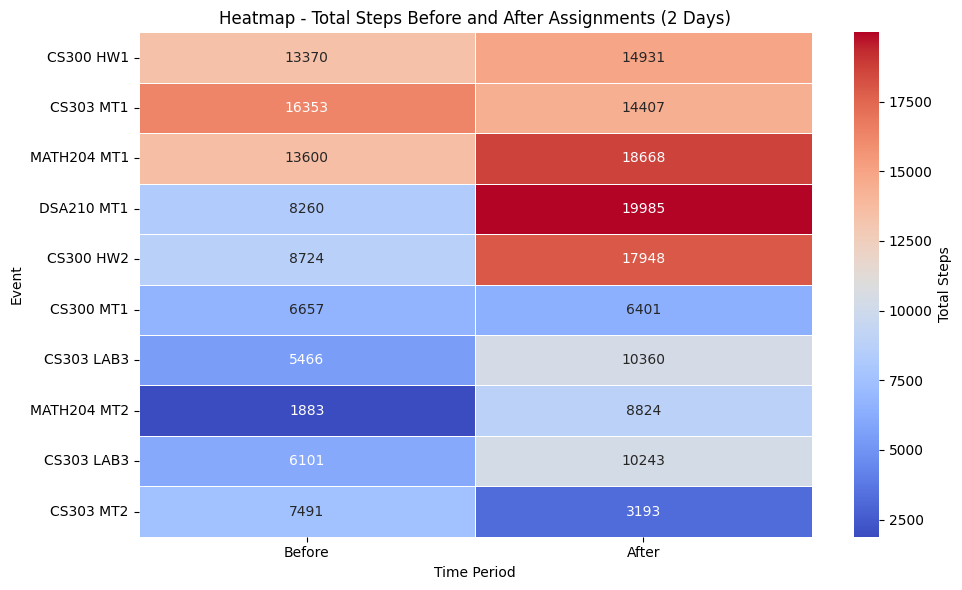

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate impact data (using total steps)
impact_data = []
for event_date, event_name in zip(event_dates, event_names):
    before_steps = daily_health_summary[daily_health_summary["Date"] < event_date].tail(2)["Steps"].sum()
    after_steps = daily_health_summary[daily_health_summary["Date"] > event_date].head(2)["Steps"].sum()
    impact_data.append({"Event": event_name, "Before": before_steps, "After": after_steps})

impact_df = pd.DataFrame(impact_data).set_index("Event")

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(impact_df, annot=True, cmap="coolwarm", fmt=".0f", linewidths=0.5, cbar_kws={"label": "Total Steps"})
plt.title("Heatmap - Total Steps Before and After Assignments (2 Days)")
plt.xlabel("Time Period")
plt.ylabel("Event")
plt.tight_layout()
plt.show()


# **Explanation of Stacked Bar Chart - Steps Before and After Assignments**

This script generates a stacked bar chart to compare the total number of steps taken before and after significant task days (assignments). The chart provides a clear visualization of activity distribution around each event.

---

## **1. Data Preparation**

### **Impact Data**
- The `impact_df` DataFrame is used as the source data.
  - Columns:
    - **Before**: Total steps taken in the two days prior to each event.
    - **After**: Total steps taken in the two days following each event.
  - Index:
    - Task/Event names representing significant assignment dates.

---

## **2. Stacked Bar Chart Creation**

### **Plotting the Chart**
- `impact_df.plot(kind="bar", stacked=True, figsize=(12, 6), color=["skyblue", "salmon"])`:
  - **Type**: Generates a stacked bar chart (`kind="bar", stacked=True`).
  - **Figure Size**: Sets the dimensions of the chart (`figsize=(12, 6)`).
  - **Colors**: Assigns intuitive colors for the bars:
    - **Before**: Sky blue.
    - **After**: Salmon.

### **Legends**
- `plt.legend(["Before", "After"], loc="upper left")`:
  - Adds a legend to distinguish "Before" and "After" values.
  - Positions the legend in the upper left corner of the chart.

---

## **3. Customization**

### **Titles and Labels**
- `plt.title`: Adds a descriptive title to explain the chart's purpose.
- `plt.ylabel`: Labels the y-axis as "Total Steps" to indicate the numeric values being plotted.
- `plt.xlabel`: Labels the x-axis as "Event" to specify the task names represented.

### **Formatting**
- `plt.tight_layout()`: Adjusts the layout to ensure all elements (bars, labels, legends) fit neatly within the figure.

---

## **4. Purpose of the Stacked Bar Chart**

The stacked bar chart provides a straightforward comparison of activity levels (steps) before and after each task day. By stacking the bars, it highlights the total activity around each event while also emphasizing the proportional differences between "Before" and "After" periods.


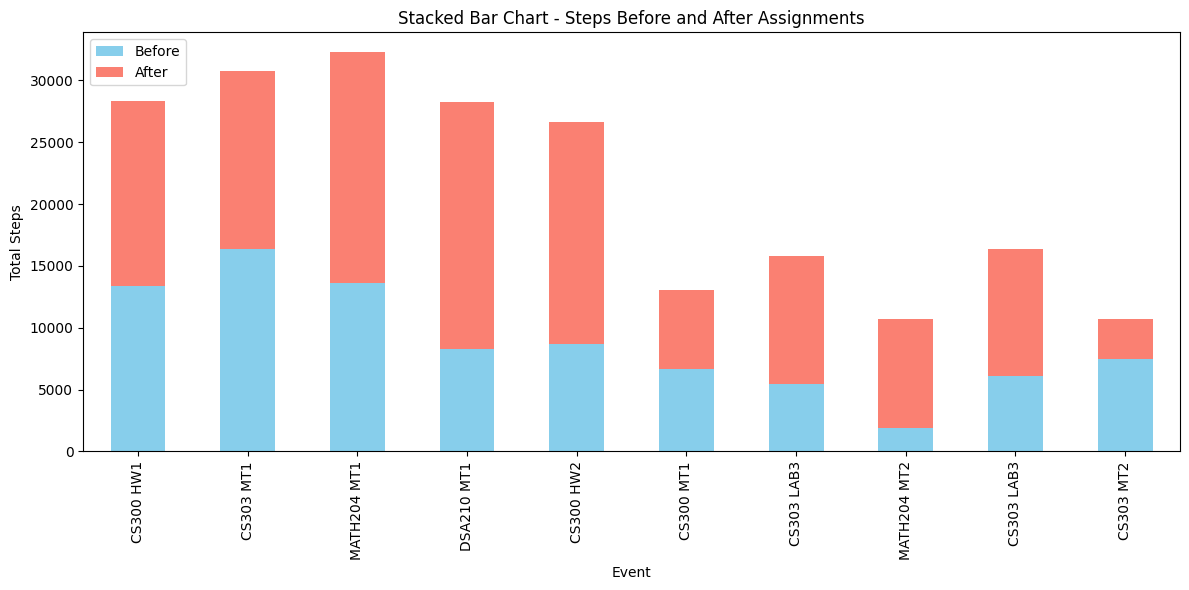

In [12]:
# Stacked bar chart
impact_df.plot(kind="bar", stacked=True, figsize=(12, 6), color=["skyblue", "salmon"])
plt.title("Stacked Bar Chart - Steps Before and After Assignments")
plt.ylabel("Total Steps")
plt.xlabel("Event")
plt.legend(["Before", "After"], loc="upper left")
plt.tight_layout()
plt.show()


# **Explanation of Box Plot - Step Count Distribution (Including 2 Days Before Task Days)**

This script generates a box plot to compare the distribution of daily step counts between normal days and task days, with task days expanded to include the two days prior to each assignment. The visualization helps analyze activity levels around task days.

---

## **1. Data Preparation**

### **Copying Data**
- `box_data = daily_health_summary.copy()`:
  - Creates a copy of the `daily_health_summary` DataFrame to avoid modifying the original data.

### **Expanding Task Days**
- **Set Initialization**: `task_days = set(event_dates)`:
  - Initializes a set containing the dates of all task days (assignment dates).
- **Expansion**:
  - For each task day in `event_dates`, the script adds:
    - **1 Day Before**: `date - pd.Timedelta(days=1)`.
    - **2 Days Before**: `date - pd.Timedelta(days=2)`.
  - These dates are added to the `task_days` set to account for activity changes before assignments.

---

## **2. Categorization**
- **Default Category**:
  - `box_data["Category"] = "Normal Day"`:
    - Assigns "Normal Day" to all rows by default.
- **Task Day Assignment**:
  - `box_data.loc[box_data["Date"].isin(task_days), "Category"] = "Task Day"`:
    - Updates the "Category" column to "Task Day" for rows where the date is in the expanded `task_days` set.

---

## **3. Visualization**

### **Box Plot**
- `sns.boxplot`:
  - **Data**: Uses the `box_data` DataFrame.
  - **X-Axis**: "Category" (Normal Day vs. Task Day).
  - **Y-Axis**: "Steps" (Daily step counts).
  - **Hue**: Differentiates the categories visually.
  - **Palette**:
    - **Normal Day**: Light steel blue.
    - **Task Day**: Indian red.
  - **Dodge**: Set to `False` for a cleaner plot.

### **Customization**
- **Title**:
  - Highlights the inclusion of two days before task days.
- **Labels**:
  - `plt.ylabel`: Adds "Steps" as the y-axis label.
- **Figure Size**:
  - Adjusted to `(12, 6)` for a clear visualization.
- **Layout**:
  - `plt.tight_layout()`: Ensures elements fit neatly.

---

## **4. Purpose of the Box Plot**

The box plot compares the distribution of step counts on normal days versus task days (expanded). It highlights differences in activity levels, providing insight into how assignments influence physical activity.


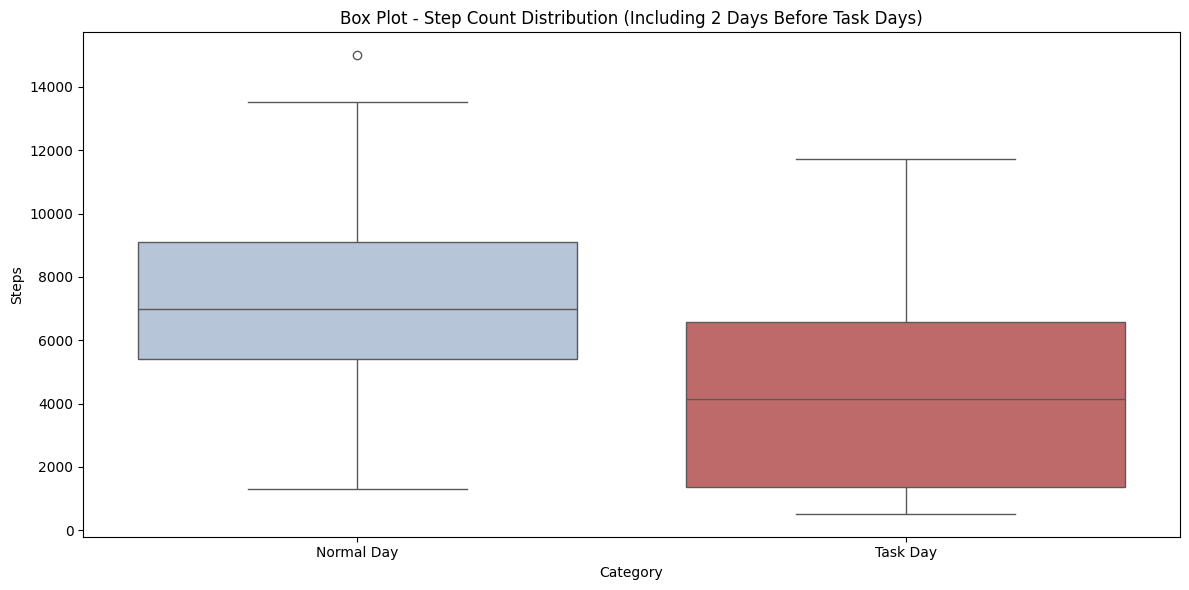

In [24]:
# Prepare box plot data
box_data = daily_health_summary.copy()

# Expand task days to include two days prior to each event
task_days = set(event_dates)
for date in event_dates:
    task_days.update([date - pd.Timedelta(days=1), date - pd.Timedelta(days=2)])

# Add 'Category' column directly to daily_health_summary
daily_health_summary["Category"] = "Normal Day"
daily_health_summary.loc[daily_health_summary["Date"].isin(task_days), "Category"] = "Task Day"


# Prepare box plot data
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=daily_health_summary,
    x="Category",
    y="Steps",
    hue="Category",
    palette={"Normal Day": "lightsteelblue", "Task Day": "indianred"},
    dodge=False
)
plt.title("Box Plot - Step Count Distribution (Including 2 Days Before Task Days)")
plt.ylabel("Steps")
plt.tight_layout()
plt.show()


# **Explanation of Horizontal Bar Chart - Difference in Steps Before and After Assignments**

This script visualizes the difference in step counts before and after assignment days using a horizontal bar chart. It helps identify trends in activity changes surrounding task days.

---

## **1. Data Preparation**

### **Creating a DataFrame for Differences**
- `impact_diff = pd.DataFrame({...}).set_index("Event")`:
  - **Event Names**: The column "Event" stores the names of tasks/assignments.
  - **Difference**: Calculates the difference in step counts:
    - `impact_df["After"] - impact_df["Before"]`:
      - **"After"**: Total steps for two days following each task.
      - **"Before"**: Total steps for two days preceding each task.
  - **Set Index**: Sets "Event" as the index for clear labeling in the bar chart.

---

## **2. Visualization**

### **Plotting the Bar Chart**
- `impact_diff.plot(kind="barh", ...)`:
  - **Horizontal Bars**:
    - `kind="barh"`: Creates a horizontal bar chart.
  - **Figure Size**: `(10, 6)` ensures the chart is large enough for readability.
  - **Color**: Bars are styled in "coral" to enhance visual appeal.
  - **Legend**: Disabled for simplicity since the chart is self-explanatory.

### **Adding Reference Line**
- `plt.axvline(0, color="black", linestyle="--")`:
  - Draws a vertical dashed line at `x=0` to indicate no difference between "Before" and "After" step counts.

### **Customization**
- **Title**:
  - Highlights the focus on differences in steps surrounding assignments.
- **X-Axis Label**:
  - Specifies "Difference (After - Before)" for clarity.
- **Y-Axis Label**:
  - Represents task/event names.
- **Layout**:
  - `plt.tight_layout()`: Ensures the chart and labels are neatly arranged.

---

## **3. Purpose of the Chart**

This horizontal bar chart highlights whether step counts increase or decrease after assignment days compared to before. Positive values (bars extending right) indicate increased activity, while negative values (bars extending left) suggest decreased activity.


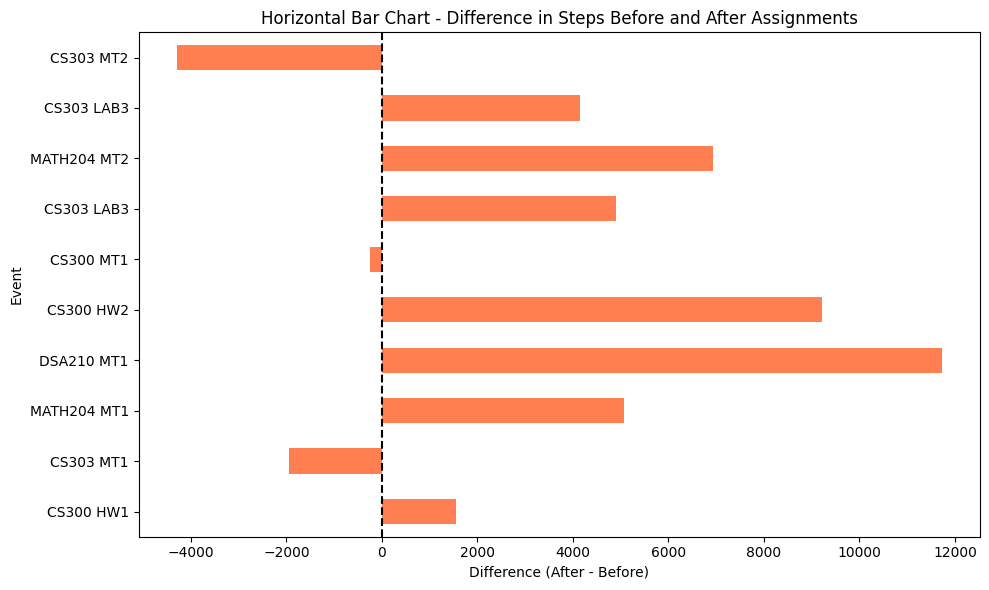

In [25]:
impact_diff = pd.DataFrame({
    "Event": event_names,
    "Difference": impact_df["After"] - impact_df["Before"]
}).set_index("Event")

impact_diff.plot(kind="barh", figsize=(10, 6), color="coral", legend=False)
plt.axvline(0, color="black", linestyle="--")
plt.title("Horizontal Bar Chart - Difference in Steps Before and After Assignments")
plt.xlabel("Difference (After - Before)")
plt.ylabel("Event")
plt.tight_layout()
plt.show()


# **Explanation of Task and Normal Days Extraction**

This document explains the process of extracting and categorizing task days (including two days before) and normal days from the dataset. The separation of these categories is crucial for conducting meaningful analyses and visualizations.

---

## **Task Days Sample Extraction**

### **Code Explanation**

1. **Objective**:
   - Extract rows labeled as "Task Day" from the `daily_health_summary` dataset.
   - Task days include the event days themselves and the two preceding days.

2. **Filtering Logic**:
   - The `"Category"` column, already defined earlier, is used to filter rows where `"Category" == 'Task Day'`.
   - This ensures that only task days and their preparation days are selected.

3. **Dropping Irrelevant Columns**:
   - The `"CumulativeSteps"` column is removed to simplify the output. This column is not required for further analysis.

4. **Output**:
   - A sample of task days is printed to verify the filtering process.


In [26]:
# Sampling data for "Task Day" and "Normal Day"
task_days_sample = daily_health_summary[daily_health_summary["Category"] == "Task Day"].drop(columns=["CumulativeSteps"])
print("Sample of Task Days and 2 days before:\n", task_days_sample)

normal_days_sample = daily_health_summary[daily_health_summary["Category"] == "Normal Day"].drop(columns=["CumulativeSteps"])
print("Sample of Normal Days:\n", normal_days_sample.head())



Sample of Task Days and 2 days before:
 Type       Date    Steps  TaskImpact Assignment  BubbleSize Color  Category
32   2024-10-25   4036.0       False    Missing          20  blue  Task Day
33   2024-10-26   9334.0       False    Missing          20  blue  Task Day
34   2024-10-27   1376.0        True   Existing         100   red  Task Day
38   2024-10-31   5298.0       False    Missing          20  blue  Task Day
39   2024-11-01  11055.0       False    Missing          20  blue  Task Day
40   2024-11-02   2545.0        True   Existing         100   red  Task Day
41   2024-11-03   5242.0        True   Existing         100   red  Task Day
46   2024-11-08   7542.0       False    Missing          20  blue  Task Day
47   2024-11-09    718.0       False    Missing          20  blue  Task Day
48   2024-11-10   6493.0        True   Existing         100   red  Task Day
53   2024-11-15   8130.0       False    Missing          20  blue  Task Day
54   2024-11-16    594.0       False    Missing 

# **Explanation of KDE Plot for Step Distributions**

This code visualizes the distribution of step counts for two categories: "Normal Day" and "Task Day." By using a **Kernel Density Estimation (KDE) plot**, it provides a smooth approximation of the probability density function for the step counts, allowing for a clearer comparison between the two categories.

---

## **1. Purpose of the KDE Plot**

The KDE plot is used to:
- Highlight the difference in step count distributions between "Normal Day" and "Task Day."
- Show whether task days exhibit a distinct pattern compared to normal days in terms of physical activity (steps taken).

---

## **2. Code Explanation**

### **a. Plot Setup**

- `plt.figure(figsize=(12, 6))`:
  - Creates a figure with a size of 12x6 inches to ensure adequate visibility of the plot.

### **b. Kernel Density Estimation (KDE) Plot**

- `sns.kdeplot(...)`:
  - **`data=daily_health_summary`**:
    - The `daily_health_summary` DataFrame provides the step count data for plotting.
  - **`x="Steps"`**:
    - The `Steps` column is used as the variable for the x-axis, representing the number of steps taken.
  - **`hue="Category"`**:
    - Differentiates the two categories, "Normal Day" and "Task Day," by plotting them with separate KDE curves.
  - **`fill=True`**:
    - Fills the area under each KDE curve, making the visual distinction between categories more pronounced.
  - **`palette={"Normal Day": "lightblue", "Task Day": "salmon"}`**:
    - Assigns specific colors to the categories:
      - **Light Blue** for "Normal Day."
      - **Salmon** for "Task Day."

### **c. Titles and Labels**

- **Title**:
  - `plt.title("Kernel Density Estimation (KDE) - Steps by Category")`:
    - Sets the plot title to explain the focus of the visualization.
- **X-Axis Label**:
  - `plt.xlabel("Steps")`:
    - Labels the x-axis with "Steps," representing the step count.
- **Y-Axis Label**:
  - `plt.ylabel("Density")`:
    - Labels the y-axis with "Density," representing the KDE values.

### **d. Layout Adjustments**

- `plt.tight_layout()`:
  - Ensures that the plot elements (e.g., titles, labels) are neatly arranged without overlapping.

### **e. Display**

- `plt.show()`:
  - Renders the KDE plot for viewing.

---

## **3. Purpose of Each Component**

| Component                       | Purpose                                                                 |
|---------------------------------|-------------------------------------------------------------------------|
| `sns.kdeplot`                   | Plots the KDE curves for step counts, highlighting category differences.|
| `fill=True`                     | Enhances visibility by shading the area under the KDE curves.           |
| `hue="Category"`                | Differentiates "Normal Day" and "Task Day" distributions.               |
| `palette={"Normal Day": ..., ...}` | Assigns distinct colors to categories for better visual distinction.    |
| `plt.tight_layout()`            | Ensures the plot layout is clean and well-organized.                    |

---

## **4. Insights Gained from the Plot**

1. **Category Comparison**:
   - The KDE plot allows for easy comparison of step count distributions between "Normal Day" and "Task Day."
2. **Activity Patterns**:
   - Peaks in the KDE curve reveal the most common step counts for each category.
3. **Overlap**:
   - The degree of overlap between the curves shows the similarity or difference in activity levels.

---

## **5. Application of the Plot**

- **Hypothesis Testing**:
  - Use the KDE plot to visually assess whether "Task Day" and "Normal Day" exhibit significantly different patterns in step counts.
- **Decision-Making**:
  - Based on the density distribution, decide if further statistical testing (e.g., t-tests) is necessary.


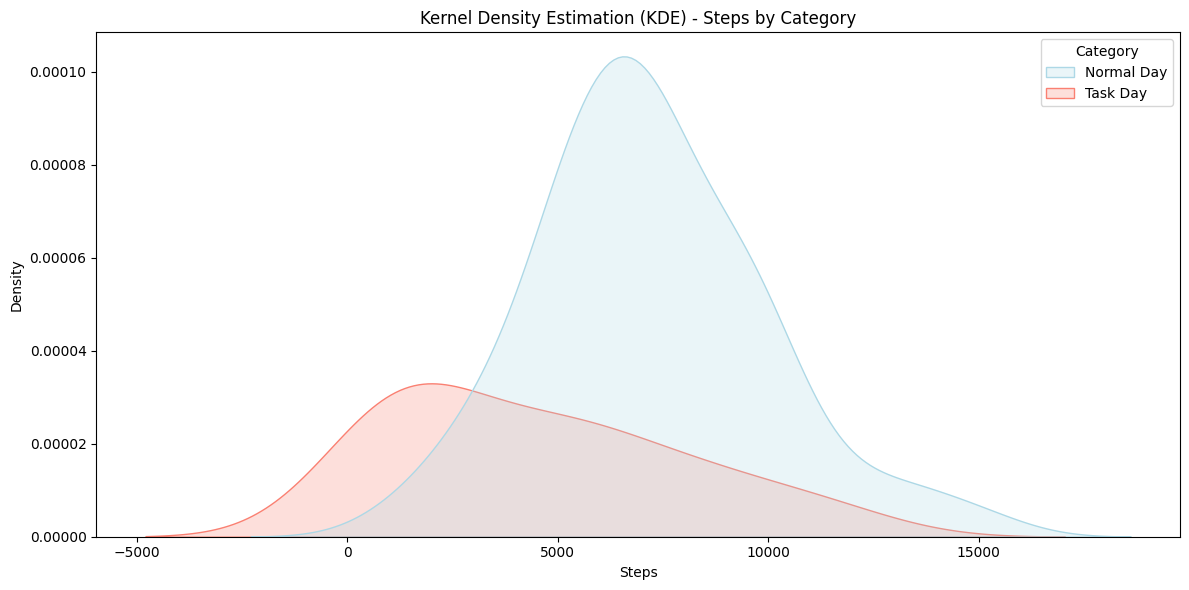

In [27]:
# KDE Plot for step distributions
plt.figure(figsize=(12, 6))
sns.kdeplot(data=daily_health_summary, x="Steps", hue="Category", fill=True, palette={"Normal Day": "lightblue", "Task Day": "salmon"})
plt.title("Kernel Density Estimation (KDE) - Steps by Category")
plt.xlabel("Steps")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


# **Explanation of T-Test for Comparing Step Counts Between Task and Normal Days**

This script performs a **t-test** to compare the mean step counts between "Task Day" and "Normal Day" categories. The test checks whether the observed differences in activity levels between the two groups are statistically significant.

---

## **1. Purpose of the T-Test**

The t-test helps determine if there is a significant difference in step counts between task days and normal days. It tests the null hypothesis:
- **Null Hypothesis (H₀)**: The mean step counts for task days and normal days are equal.
- **Alternative Hypothesis (H₁)**: The mean step counts for task days and normal days are significantly different.

---

## **2. Code Explanation**

### **a. Data Splitting**

- **Task Days**:
  - `task_steps = daily_health_summary[daily_health_summary["Category"] == "Task Day"]["Steps"]`
  - Filters the `daily_health_summary` DataFrame to extract step counts for rows labeled as "Task Day."
- **Normal Days**:
  - `normal_steps = daily_health_summary[daily_health_summary["Category"] == "Normal Day"]["Steps"]`
  - Filters the DataFrame for rows labeled as "Normal Day."

### **b. Perform T-Test**

- **`ttest_ind(...)`**:
  - A t-test is performed to compare the means of the two groups.
  - **`equal_var=False`**:
    - Assumes unequal variances between the two groups (Welch’s t-test), which is robust for samples with differing variances or sizes.
  - **Outputs**:
    - `t_stat`: The calculated t-statistic value.
    - `p_value`: The probability of observing a difference as extreme as the one seen, assuming the null hypothesis is true.

### **c. Display Results**

- **T-Statistic**:
  - Indicates the magnitude of the difference between the groups relative to their variability.
- **P-Value**:
  - Used to decide whether to reject the null hypothesis:
    - **`p_value < 0.05`**: Significant difference; reject the null hypothesis.
    - **`p_value >= 0.05`**: No significant difference; fail to reject the null hypothesis.

### **d. Interpretation of Results**

- If the p-value is below 0.05:
  - The difference in step counts between task and normal days is statistically significant.
- Otherwise:
  - The observed difference is not statistically significant, and the null hypothesis cannot be rejected.


In [28]:
from scipy.stats import ttest_ind

# Split data into Task and Normal days
task_steps = daily_health_summary[daily_health_summary["Category"] == "Task Day"]["Steps"]
normal_steps = daily_health_summary[daily_health_summary["Category"] == "Normal Day"]["Steps"]

# Perform T-Test
t_stat, p_value = ttest_ind(task_steps, normal_steps, equal_var=False)
print("T-Test Results:")
print("T-Statistic:", t_stat)
print("P-Value:", p_value)

# Interpret the result
if p_value < 0.05:
    print("Result: Reject the null hypothesis - Significant difference in step counts between groups.")
else:
    print("Result: Fail to reject the null hypothesis - No significant difference in step counts between groups.")



T-Test Results:
T-Statistic: -3.5644961672221007
P-Value: 0.0009643623761957361
Result: Reject the null hypothesis - Significant difference in step counts between groups.


# **Explanation of Mann-Whitney U Test for Step Count Comparison**

The Mann-Whitney U test is a **non-parametric test** used to compare the distributions of two independent groups. Unlike a t-test, it does not assume normality of the data, making it ideal for non-normally distributed or ordinal data.

---

## **1. Purpose of the Mann-Whitney U Test**

The test determines whether the distributions of step counts for "Task Day" and "Normal Day" groups are significantly different.

- **Null Hypothesis (H₀)**: The distributions of step counts for task days and normal days are identical.
- **Alternative Hypothesis (H₁)**: The distributions of step counts for task days and normal days differ significantly.

---

## **2. Code Explanation**

### **a. Perform Mann-Whitney U Test**

- **`mannwhitneyu(...)`**:
  - Compares the distributions of step counts for task and normal days.
  - **Inputs**:
    - `task_steps`: Step counts on task days.
    - `normal_steps`: Step counts on normal days.
    - `alternative="two-sided"`: Tests for any difference (not just greater or lesser).
  - **Outputs**:
    - `u_stat`: The Mann-Whitney U statistic, representing the number of times a value from one group precedes a value from the other group.
    - `p_value`: The probability of observing a U statistic as extreme as the one calculated, assuming the null hypothesis is true.

### **b. Display Results**

- **U-Statistic**:
  - A measure of the rank-based difference between the two groups.
- **P-Value**:
  - Used to decide whether to reject the null hypothesis:
    - **`p_value < 0.05`**: Significant difference; reject the null hypothesis.
    - **`p_value >= 0.05`**: No significant difference; fail to reject the null hypothesis.

### **c. Interpretation of Results**

- If the p-value is below 0.05:
  - The distributions of step counts for task and normal days are significantly different.
- Otherwise:
  - There is insufficient evidence to conclude a difference in distributions.

In [29]:
from scipy.stats import mannwhitneyu

# Perform Mann-Whitney U Test
u_stat, p_value = mannwhitneyu(task_steps, normal_steps, alternative="two-sided")
print("Mann-Whitney U Test Results:")
print("U-Statistic:", u_stat)
print("P-Value:", p_value)

# Interpret the result
if p_value < 0.05:
    print("Result: Reject the null hypothesis - Significant difference in step counts between groups.")
else:
    print("Result: Fail to reject the null hypothesis - No significant difference in step counts between groups.")



Mann-Whitney U Test Results:
U-Statistic: 393.0
P-Value: 0.0004865124080968713
Result: Reject the null hypothesis - Significant difference in step counts between groups.


# **Explanation of Kruskal-Wallis Test for Step Count Comparison**

The Kruskal-Wallis test is a **non-parametric statistical test** that determines if there are statistically significant differences between the medians of two or more independent groups. It is an extension of the Mann-Whitney U test for more than two groups but is often used for two groups as well.

---

## **1. Purpose of the Kruskal-Wallis Test**

- To compare step counts for "Task Day" and "Normal Day" groups to determine if their distributions differ significantly.
- Unlike parametric tests, the Kruskal-Wallis test does not assume normality or equal variances.

### **Hypotheses**:
- **Null Hypothesis (H₀)**: The distributions of step counts for the groups are identical.
- **Alternative Hypothesis (H₁)**: At least one group has a different distribution.

---

## **2. Code Explanation**

### **a. Splitting Data into Groups**

- **`task_steps`**:
  - Contains step counts for task days.
  - Extracted using `daily_health_summary["Category"] == "Task Day"`.
- **`normal_steps`**:
  - Contains step counts for normal days.
  - Extracted using `daily_health_summary["Category"] == "Normal Day"`.

### **b. Performing the Kruskal-Wallis Test**

- **`kruskal(task_steps, normal_steps)`**:
  - Compares the two groups for differences in their distributions.
  - **Inputs**:
    - `task_steps`: Step counts for task days.
    - `normal_steps`: Step counts for normal days.
  - **Outputs**:
    - `stat`: The Kruskal-Wallis H statistic, a rank-based measure of group differences.
    - `p_value`: The probability of observing the given or more extreme H statistic, assuming the null hypothesis is true.

### **c. Interpreting the Result**

- **`if p_value < 0.05:`**:
  - Reject the null hypothesis.
  - Indicates significant differences between the groups.
- **`else:`**:
  - Fail to reject the null hypothesis.
  - Suggests no significant differences in the distributions.


In [56]:
from scipy.stats import kruskal

# Split data into groups based on the category
task_steps = daily_health_summary[daily_health_summary["Category"] == "Task Day"]["Steps"]
normal_steps = daily_health_summary[daily_health_summary["Category"] == "Normal Day"]["Steps"]

# Perform Kruskal-Wallis test
stat, p_value = kruskal(task_steps, normal_steps)

print("Kruskal-Wallis Test Results:")
print("Test Statistic:", stat)
print("P-Value:", p_value)

# Interpret the result
if p_value < 0.05:
    print("Result: Reject the null hypothesis - Significant difference in step counts between groups.")
else:
    print("Result: Fail to reject the null hypothesis - No significant difference in step counts between groups.")


Kruskal-Wallis Test Results:
Test Statistic: 12.200436885629586
P-Value: 0.00047778325337349874
Result: Reject the null hypothesis - Significant difference in step counts between groups.
